In [1]:
import os, datetime, time, re, warnings, gc, json, random, yaml, pickle

from contextlib import contextmanager

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.core.common import SettingWithCopyWarning

from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", 256)
pd.set_option("display.max_rows", 256)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Noto Sans CJK JP']

In [2]:
df = pd.read_pickle("./structure_df_01.pkl")
df.head()

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,14,392,1,6,0,9
1,79 08B250B,国立音楽大学新校舎建設工事,大学,東京都立川市,17277.40,0-0-0,RC造,13,392,0,0,0,0
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,13,392,0,1,0,2
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,事務所,新潟県五泉市,3400.00,0-3-0,S造,15,392,0,3,0,2
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,生産施設,海外タイ アユタヤ県,500.00,0-0-0,RC造,55,764,0,0,0,1


### 処理済み特徴量の読み込み

In [3]:
train = pd.read_pickle("./structure_train_01.pkl")
train.head()

,floor_area,pref_code,country_code,floor_1,floor_2,floor_3,CB造,PC造,RC造,SC造,SRC造,S造,W造,-999,事務所,体育館,保育所,個人住宅,卸売市場,商業施設,大学,娯楽施設,宿泊施設,廃棄物処理場,教育施設,物流施設,物販店舗,生産施設,病院施設,発電所,看板,研修施設,研究施設,社寺教会,福祉施設,集合住宅,飲食店,駐車場
0,0.227064,-0.531081,-0.108556,1.021981,0.295825,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.058988,-0.598493,-0.108556,-0.325103,-0.822874,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.528114,-0.598493,-0.108556,-0.325103,-0.636424,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,-0.413403,-0.463669,-0.108556,-0.325103,-0.263525,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.512119,2.232811,6.366625,-0.325103,-0.822874,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### クラスタリング

In [4]:
kmeans = MiniBatchKMeans(n_clusters=10, random_state=42)
kmeans.fit(train)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

### 分類結果を分析用のデータに反映

In [5]:
df["k_class"] = kmeans.predict(train)

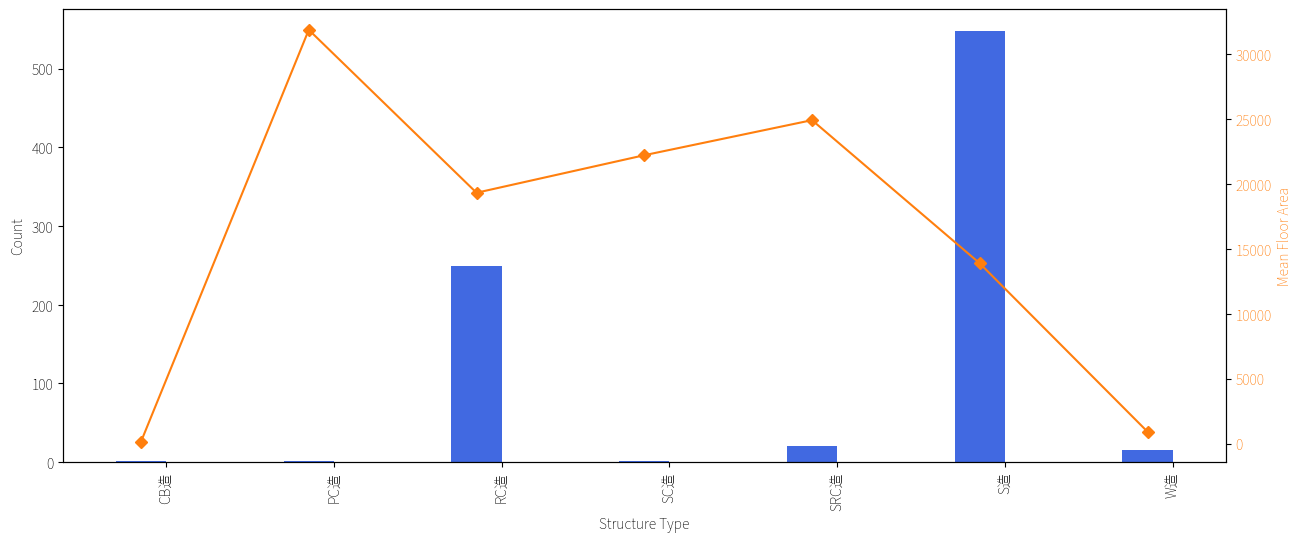

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), dpi=100)
tt = df.groupby("structure_type").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Structure Type");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(np.sort(df["structure_type"].unique()), rotation=90)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("structure_type")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean Floor Area', color='tab:orange');

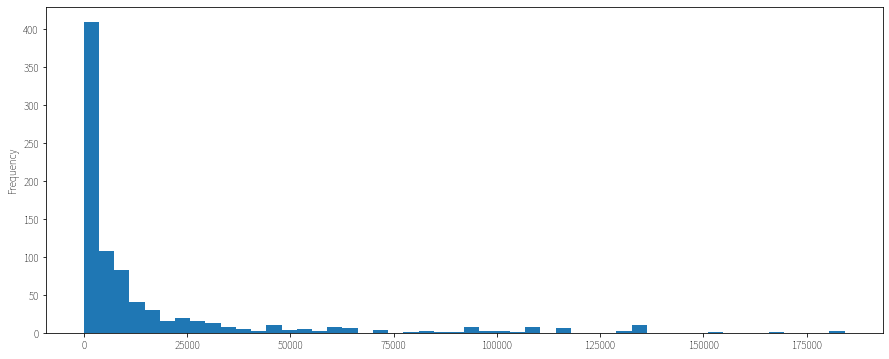

In [7]:
plt.rc('figure', figsize=(15, 6))
df["floor_area"].plot.hist(bins=50)

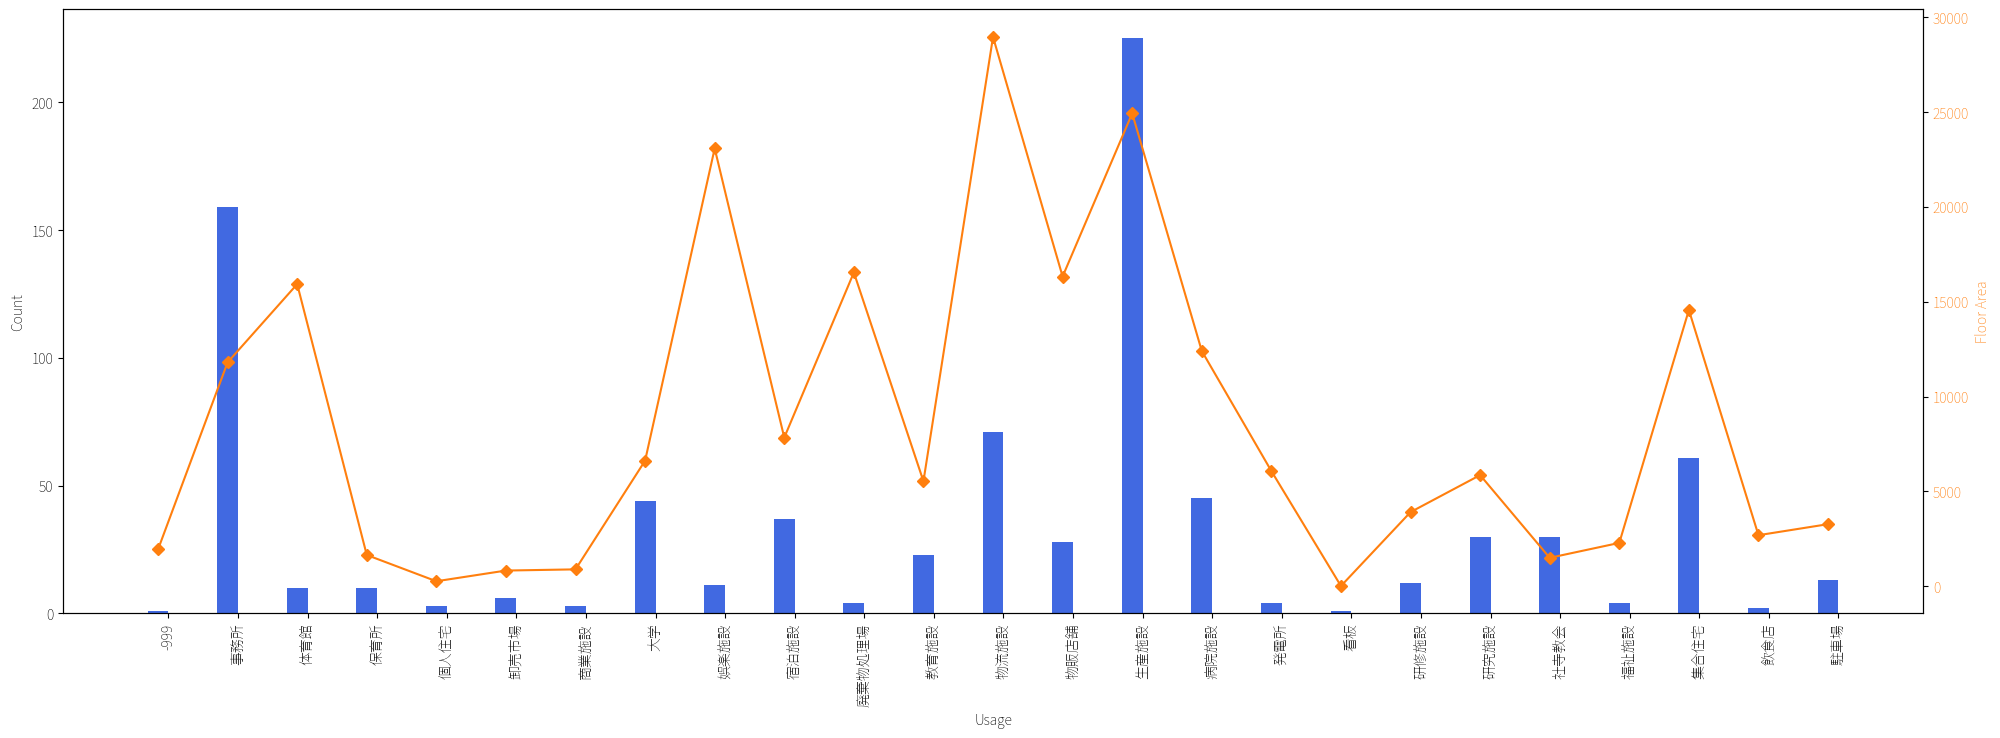

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(24, 8), dpi=100)
df["usage"] = df["usage"].astype(str)
tt = df.groupby("usage").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Usage");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(np.sort(df["usage"].unique()), rotation=90)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("usage")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Floor Area', color='tab:orange');

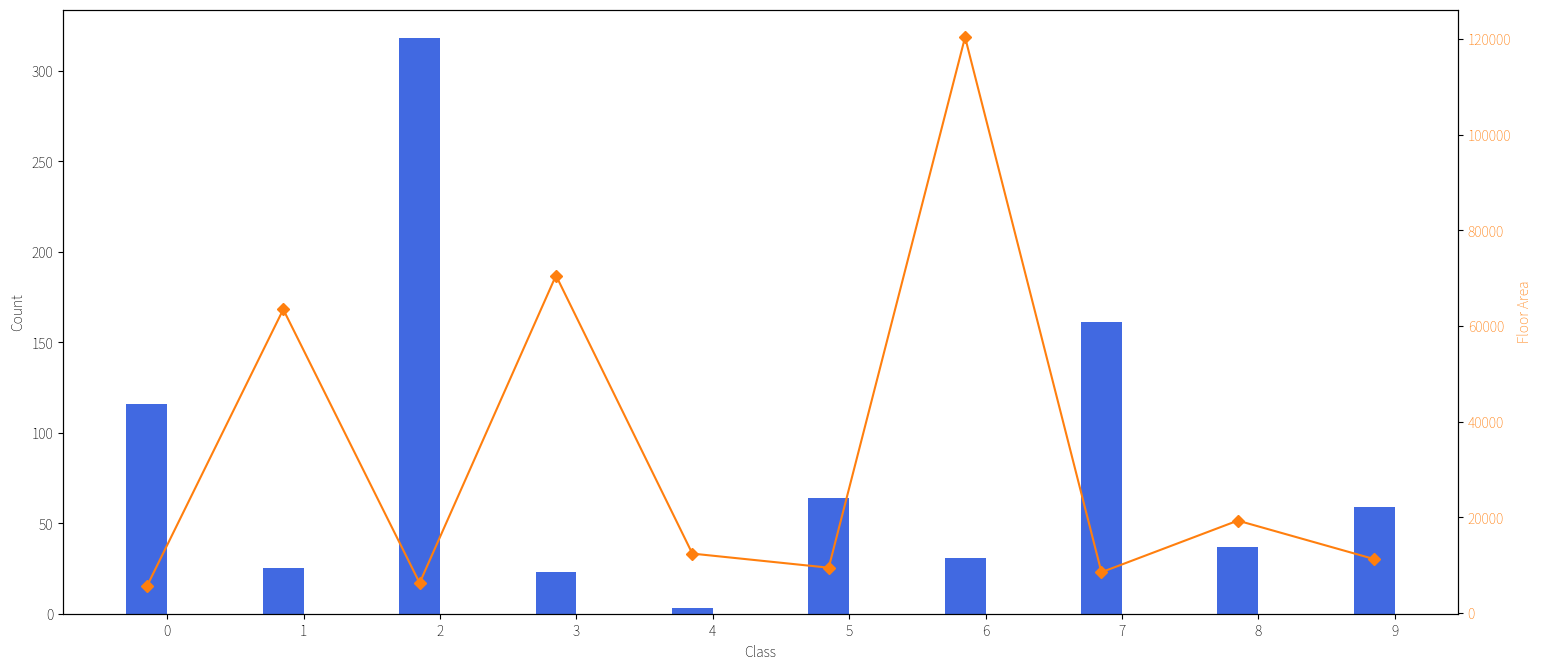

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(18, 8), dpi=100)
tt = df.groupby("k_class").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Class");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(np.sort(df["k_class"].unique()), rotation=0)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("k_class")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Floor Area', color='tab:orange');

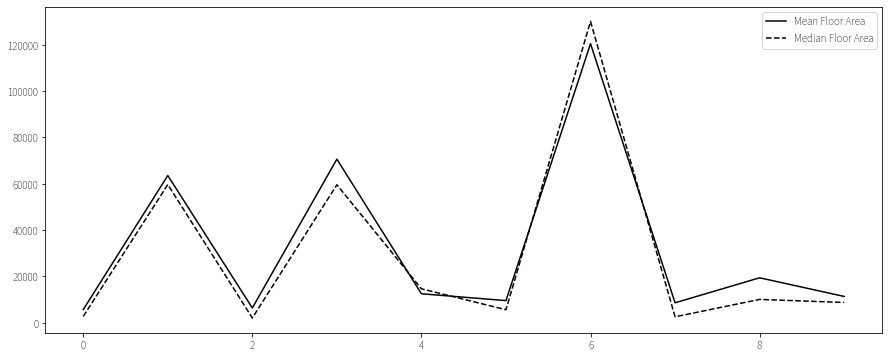

In [10]:
fig = plt.figure(); ax = fig.add_subplot(1, 1, 1)
ax.plot(df.groupby("k_class")["floor_area"].mean(), 'k', label='Mean Floor Area')
ax.plot(df.groupby("k_class")["floor_area"].median(), 'k--', label='Median Floor Area')
ax.legend(loc='best')

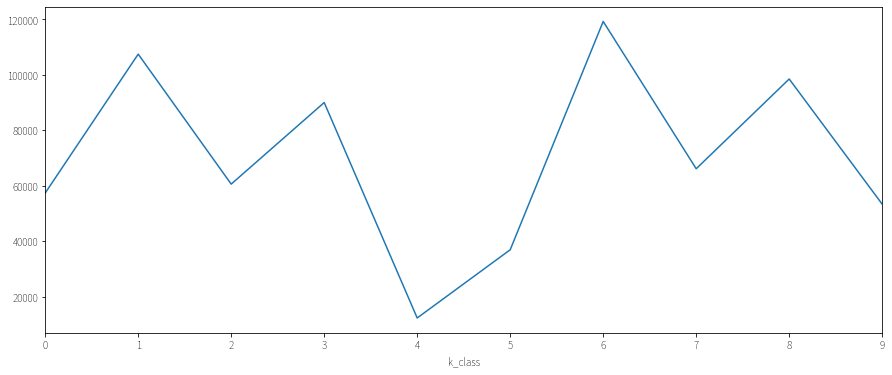

In [11]:
tmp = df.groupby("k_class").agg({"floor_area": ["min", "max"]})
tmp["diff"] = tmp[("floor_area", "max")] - tmp[("floor_area", "min")]
tmp["diff"].plot()

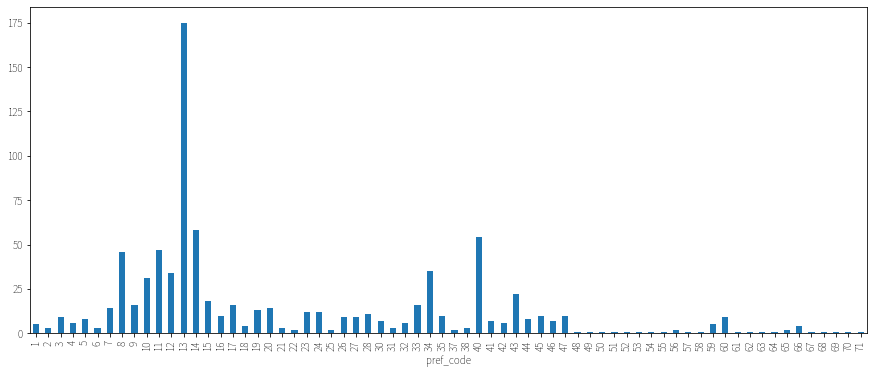

In [12]:
df.groupby("pref_code").size().plot.bar()

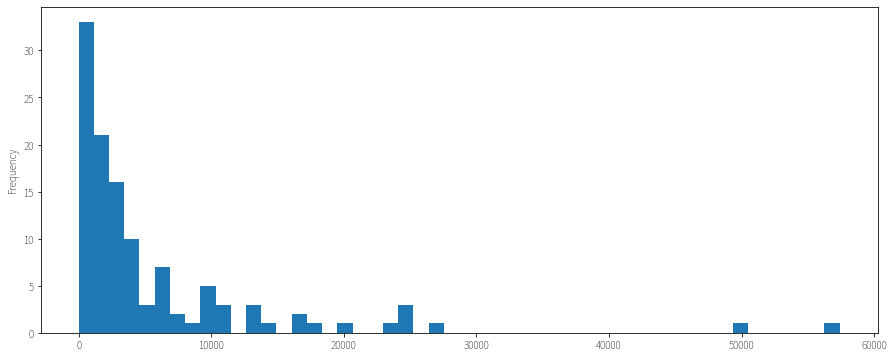

In [13]:
df[df["k_class"]==0]["floor_area"].plot.hist(bins=50)

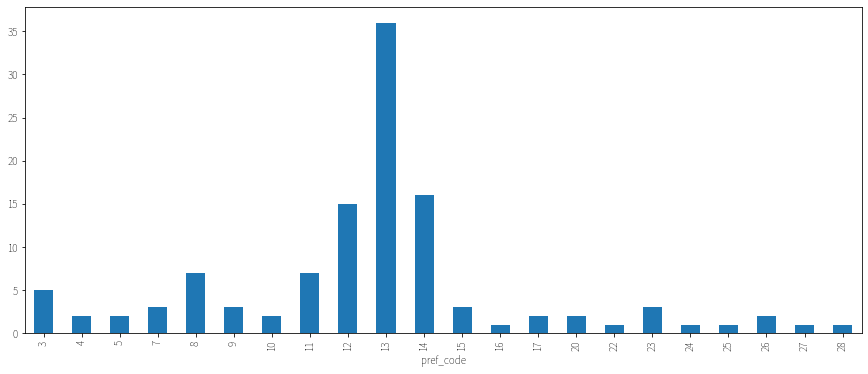

In [14]:
df[df["k_class"]==0].groupby("pref_code").size().plot.bar()

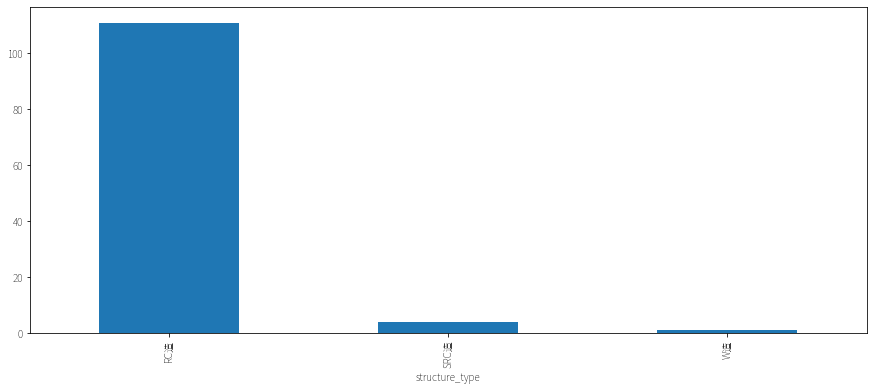

In [15]:
df[df["k_class"]==0].groupby("structure_type").size().plot.bar()

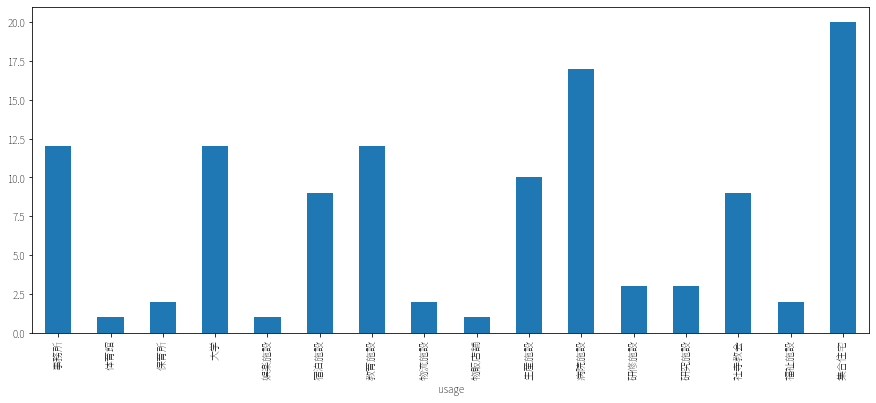

In [16]:
df[df["k_class"]==0].groupby("usage").size().plot.bar()

In [17]:
df[df["k_class"]==0]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
1,79 08B250B,国立音楽大学新校舎建設工事,大学,東京都立川市,17277.40,0-0-0,RC造,13,392,0,0,0,0
9,79 08B129F,慶應義塾（矢上Ｆ）テクロノジー棟新築,大学,神奈川県横浜市港北区,1895.78,0-3-0,RC造,14,392,0,3,0,0
16,79 09A255B,伊豆ベロドローム建設計画,娯楽施設,静岡県伊豆市,12905.00,1-3-0,RC造,22,392,1,3,0,0
22,79 08B129J,慶應義塾（矢上Ｊ）付属棟移転①（自工研）,大学,神奈川県横浜市港北区,125.00,0-1-0,RC造,14,392,0,1,0,0
23,79 07B503C,目黒不動尊瀧泉寺供養塔新築工事,社寺教会,東京都目黒区,3.98,0-1-0,RC造,13,392,0,1,0,0
27,70 09A014,百五銀行豊田支店計画,事務所,愛知県豊田市,744.84,0-2-0,RC造,23,392,0,2,0,0
39,79 09A116B,国際神南ビル建替計画,集合住宅,東京都渋谷区,1350.90,0-9-0,RC造,13,392,0,9,0,0
53,79 10A432B,ＡＤＥＫＡ浦和新研究棟建設工事,研究施設,埼玉県さいたま市南区,7017.04,0-7-0,RC造,11,392,0,7,0,0
56,79 03B790F,オリンパス石川再開発共用棟新築工事,研究施設,東京都八王子市,3239.00,0-2-0,RC造,13,392,0,2,0,0
60,79 10A437A,※東急瀬田四丁目計画,集合住宅,東京都世田谷区,3404.54,1-3-0,RC造,13,392,1,3,0,0


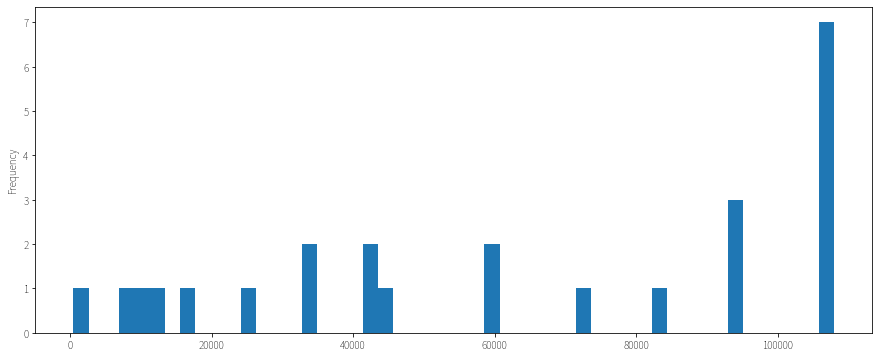

In [18]:
df[df["k_class"]==1]["floor_area"].plot.hist(bins=50)

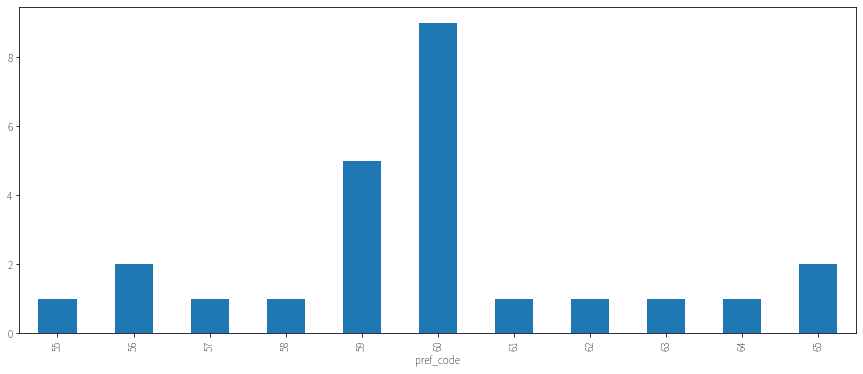

In [19]:
df[df["k_class"]==1].groupby("pref_code").size().plot.bar()

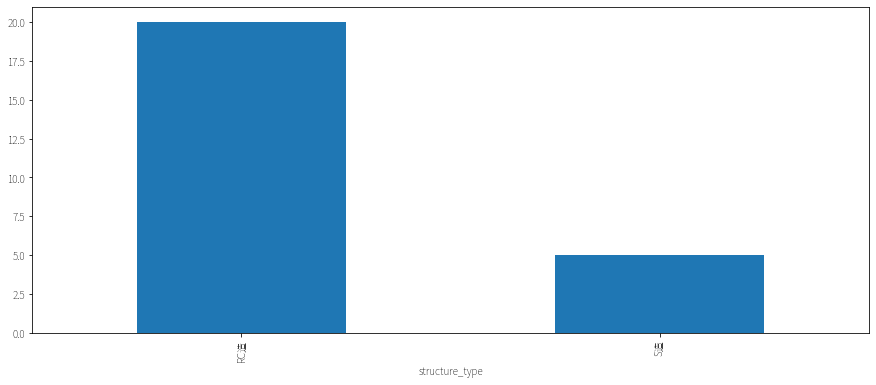

In [20]:
df[df["k_class"]==1].groupby("structure_type").size().plot.bar()

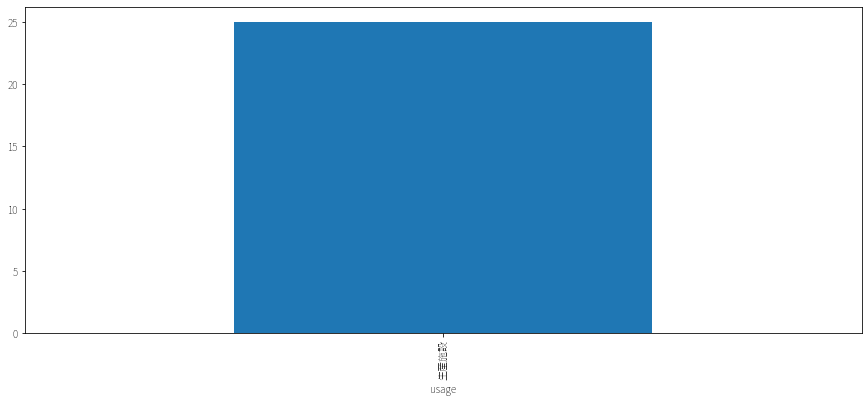

In [21]:
df[df["k_class"]==1].groupby("usage").size().plot.bar()

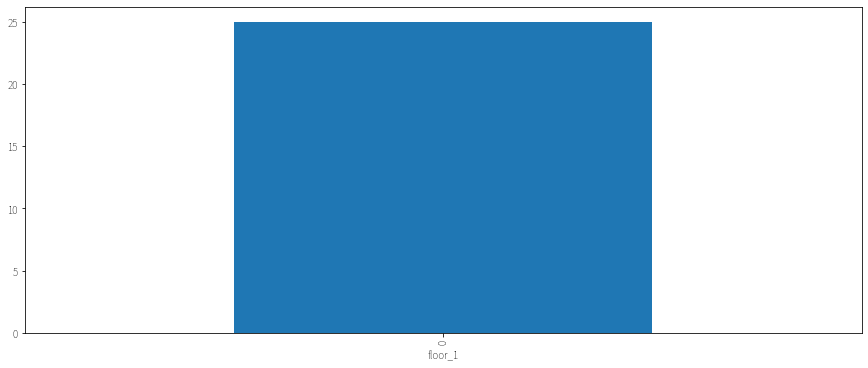

In [22]:
df[df["k_class"]==1].groupby("floor_1").size().plot.bar()

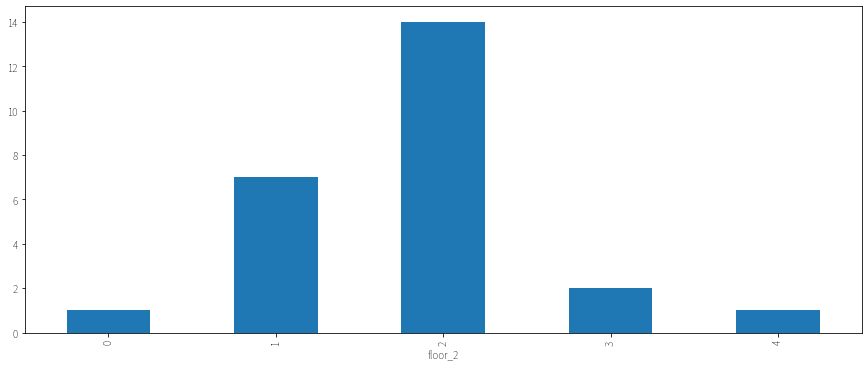

In [23]:
df[df["k_class"]==1].groupby("floor_2").size().plot.bar()

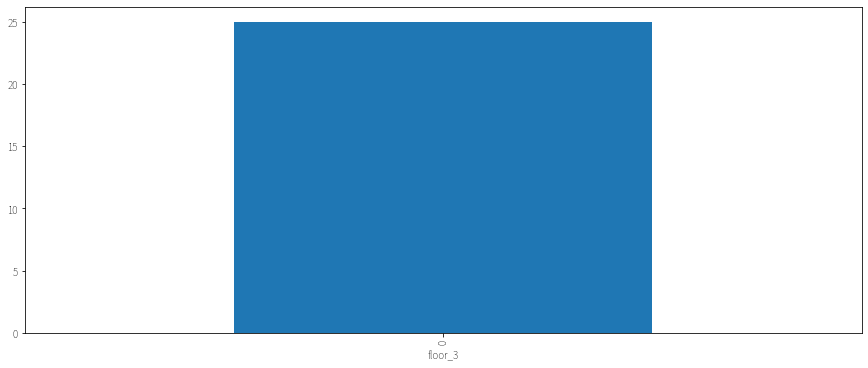

In [24]:
df[df["k_class"]==1].groupby("floor_3").size().plot.bar()

In [25]:
df[df["k_class"]==1]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,生産施設,海外タイ アユタヤ県,500.00,0-0-0,RC造,55,764,0,0,0,1
21,93 09A037,Ｐ＆ＧベトナムＢｅｎＣａｔ工場新築工事,生産施設,海外ベトナム ビンドゥオン,15900.00,0-2-0,S造,63,704,0,2,0,1
105,93 09B052,ベトナム・デンヨーＴＬＩＰ計画,生産施設,海外ベトナム ﾌﾝｲｴﾝ,12700.00,0-1-0,S造,64,704,0,1,0,1
188,79 11B392A,キヤノンフィリピン工場新築工事,生産施設,海外フィリピン バタンガス州,83437.69,0-2-0,RC造,61,608,0,2,0,1
301,79 12A676B,富士ゼロックス海外新生産拠点建設工事,生産施設,海外ベトナム・ハイフォン市,59598.68,0-2-0,S造,65,704,0,2,0,1
305,79 12A676C,富士ゼロックス海外新生産拠点建設工事,生産施設,海外ベトナム・ハイフォン市,59598.67,0-2-0,S造,65,704,0,2,0,1
379,79 11B427A,東芝半導体工場タイ（ＴＳＴ）４期工事,生産施設,海外タイ バンコク近郊,43349.00,0-3-1,RC造,56,764,0,3,0,1
383,79 11B427B,東芝半導体工場タイ（ＴＳＴ）追加工事,生産施設,海外タイ バンコク近郊,43349.00,0-4-0,RC造,56,764,0,4,0,1
418,79 13A351A,※ホンダ４輪プラチンブリ新工場,生産施設,海外タイ・プラチンブリ県,94574.00,0-1-0,RC造,59,764,0,1,0,1
448,93 13A032A,ホンダ４輪プラチンブリエンジン新工場,生産施設,海外タイ プラチンブリ県,73570.00,0-1-0,RC造,58,764,0,1,0,1


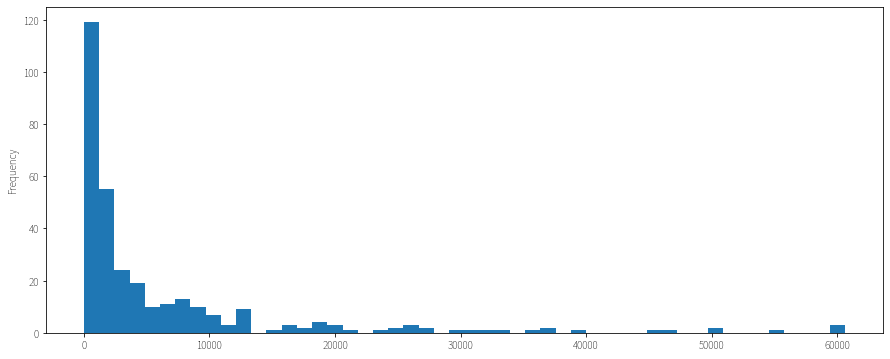

In [26]:
df[df["k_class"]==2]["floor_area"].plot.hist(bins=50)

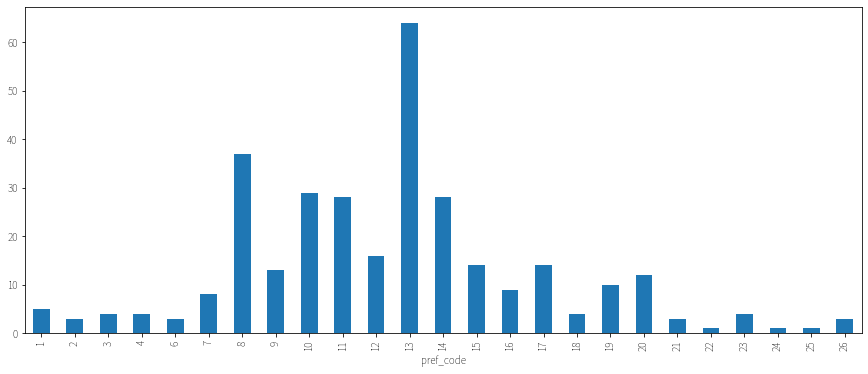

In [27]:
df[df["k_class"]==2].groupby("pref_code").size().plot.bar()

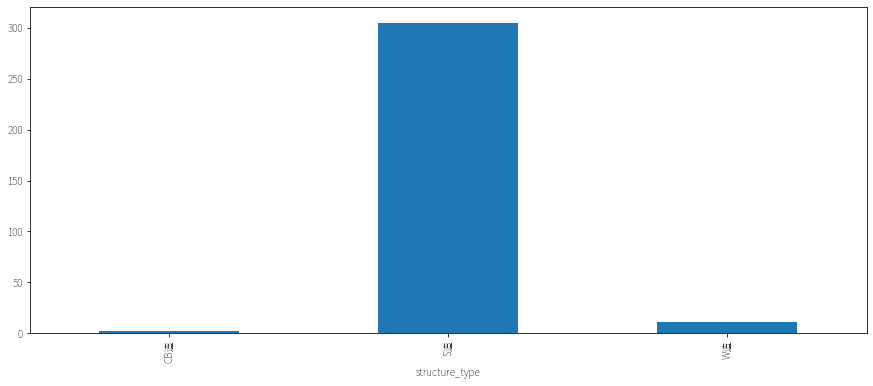

In [28]:
df[df["k_class"]==2].groupby("structure_type").size().plot.bar()

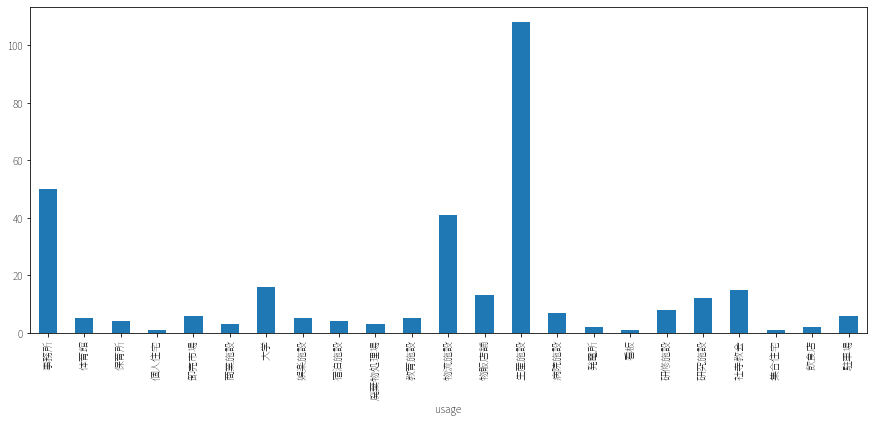

In [29]:
df[df["k_class"]==2].groupby("usage").size().plot.bar()

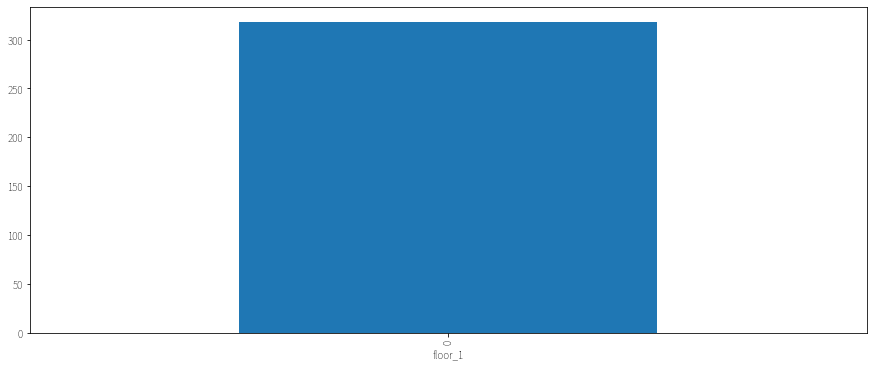

In [30]:
df[df["k_class"]==2].groupby("floor_1").size().plot.bar()

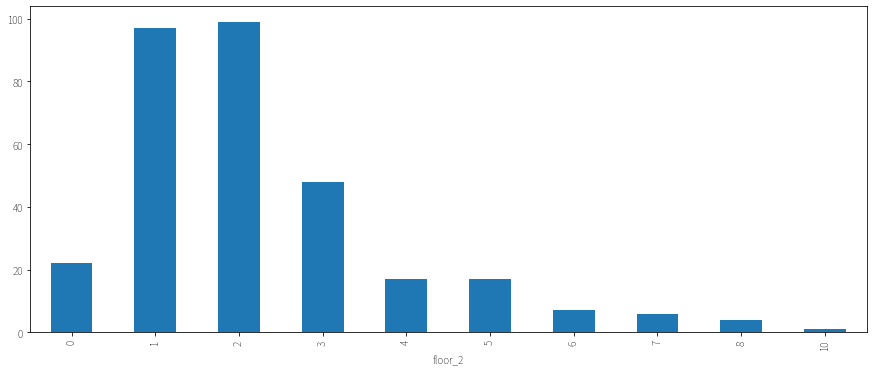

In [31]:
df[df["k_class"]==2].groupby("floor_2").size().plot.bar()

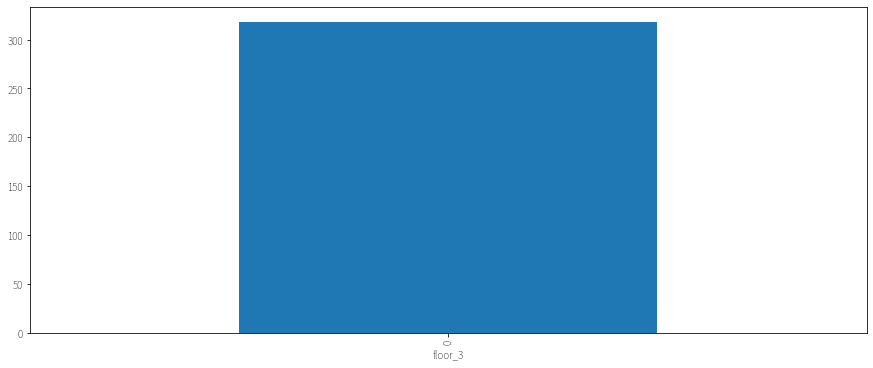

In [32]:
df[df["k_class"]==2].groupby("floor_3").size().plot.bar()

In [33]:
df[df["k_class"]==2]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,13,392,0,1,0,2
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,事務所,新潟県五泉市,3400.00,0-3-0,S造,15,392,0,3,0,2
10,79 04A763E,島忠調布店新築工事（工期延長後）,物販店舗,東京都調布市,50000.00,0-6-0,S造,13,392,0,6,0,2
13,79 04A763D,島忠調布店新築工事（テナント対応）,物販店舗,東京都調布市,50000.00,0-6-0,S造,13,392,0,6,0,2
26,79 09A396A,東芝府中事業所１２Ａ棟新築工事,事務所,東京都府中市,32301.00,0-4-0,S造,13,392,0,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,64 17B037,サカイ上田営業所新築工事,事務所,長野県上田市,660.00,0-2-0,S造,20,392,0,2,0,2
826,79 15A255B,穴八幡宮手水舎・布袋像覆屋新築・追加,社寺教会,東京都新宿区,17.00,0-1-0,W造,13,392,0,1,0,2
830,76 18A020,日本生命会郡山支社会津営業部新築工事,事務所,福島県会津若松市,379.00,0-1-0,S造,7,392,0,1,0,2
834,64 18A047,関東電化工業渋川工場高圧ガス容器置場新築,物流施設,群馬県渋川市,214.00,0-1-0,S造,10,392,0,1,0,2


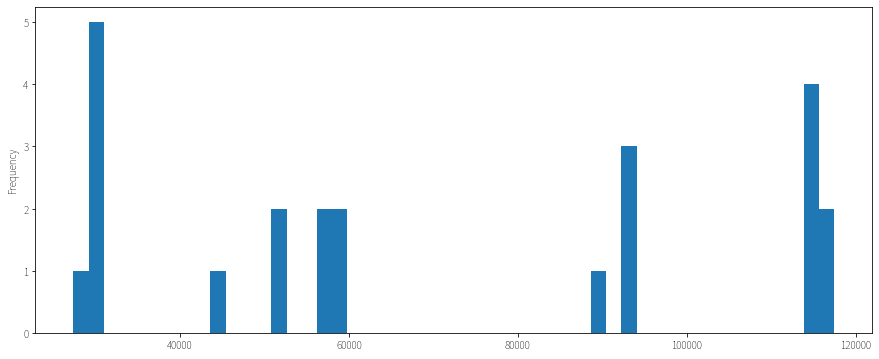

In [34]:
df[df["k_class"]==3]["floor_area"].plot.hist(bins=50)

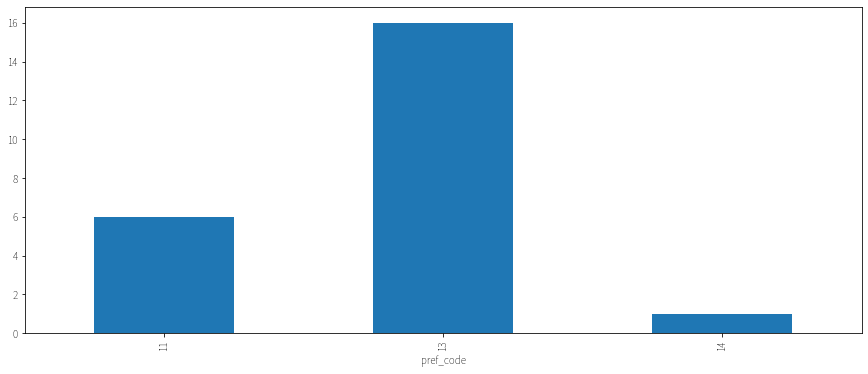

In [35]:
df[df["k_class"]==3].groupby("pref_code").size().plot.bar()

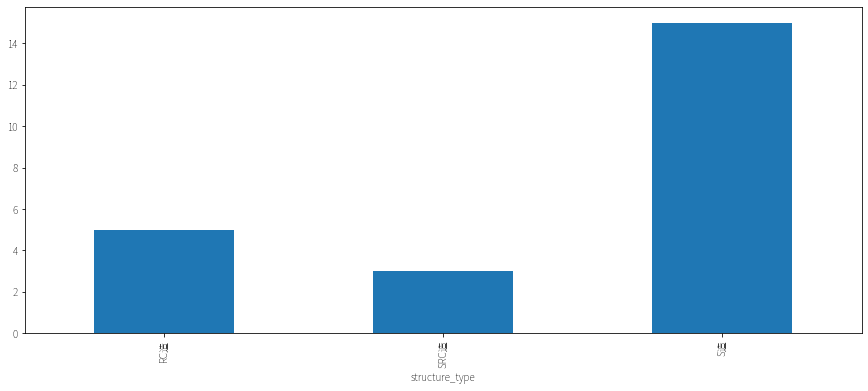

In [36]:
df[df["k_class"]==3].groupby("structure_type").size().plot.bar()

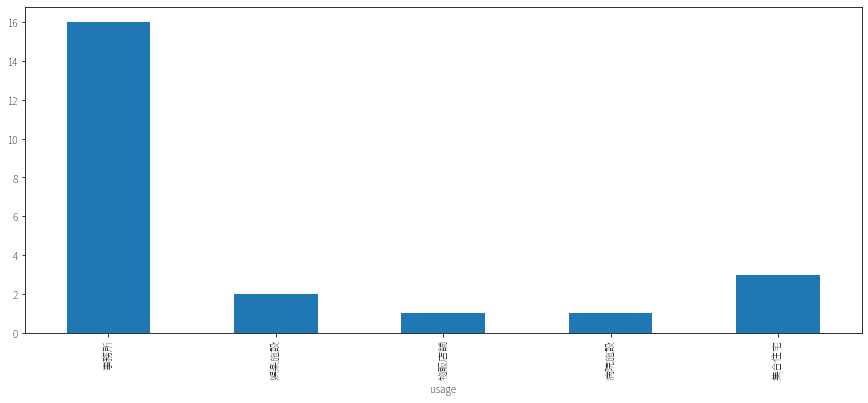

In [37]:
df[df["k_class"]==3].groupby("usage").size().plot.bar()

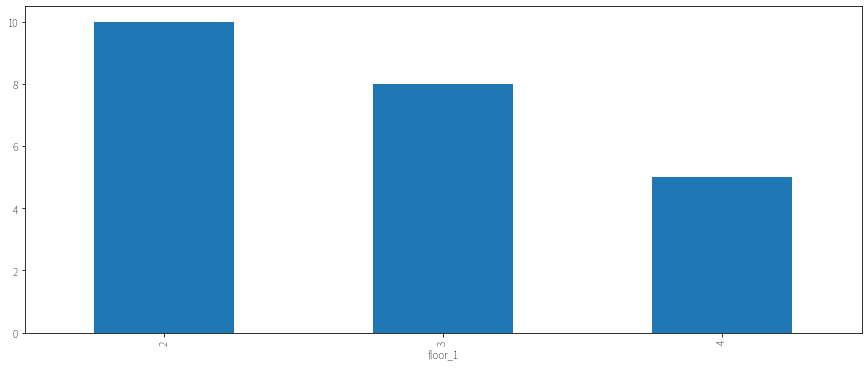

In [38]:
df[df["k_class"]==3].groupby("floor_1").size().plot.bar()

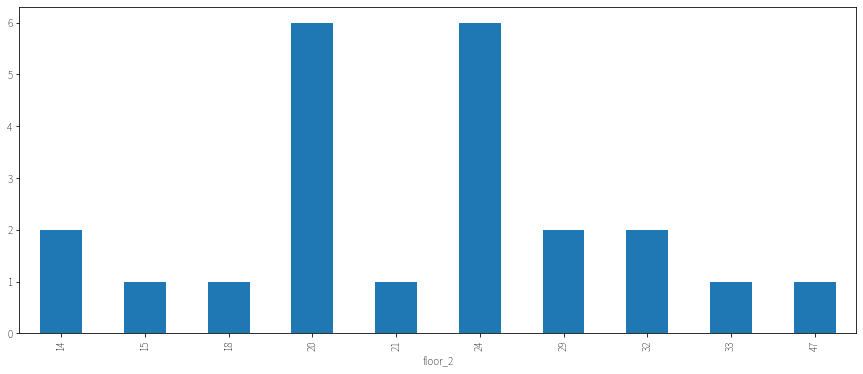

In [39]:
df[df["k_class"]==3].groupby("floor_2").size().plot.bar()

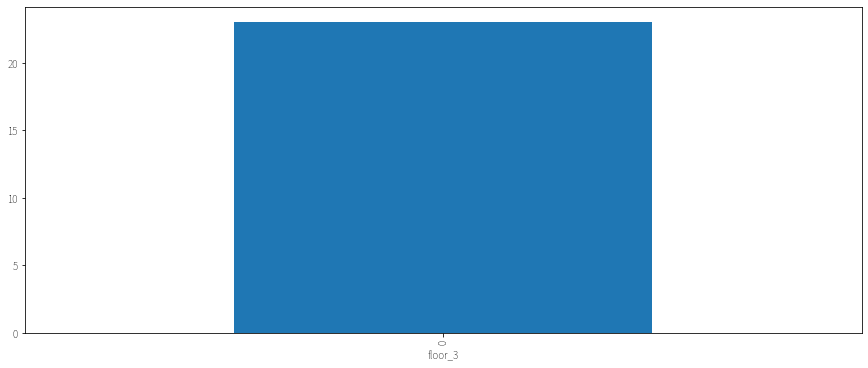

In [40]:
df[df["k_class"]==3].groupby("floor_3").size().plot.bar()

In [41]:
df[df["k_class"]==3]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
19,79 09A190B,京橋三丁目プロジェクト,事務所,東京都中央区,117460.96,4-24-0,S造,13,392,4,24,0,3
31,79 09A333B,順天堂本郷地区再編事業（実施設計）,病院施設,東京都文京区,45385.87,3-21-0,S造,13,392,3,21,0,3
78,79 09A190D,京橋三丁目プロジェクト設計変更対応,事務所,東京都中央区,116319.00,3-24-0,S造,13,392,3,24,0,3
98,79 08B315C,中央合同庁舎第８号館整備（内閣府ＰＦＩ）,事務所,東京都千代田区,52349.29,3-15-1,RC造,13,392,3,15,0,3
115,79 08B315D,中央合同庁舎第８号館整備（内閣府ＰＦＩ）,事務所,東京都千代田区,51000.00,4-14-0,RC造,13,392,4,14,0,3
146,79 09B056D,ＪＲ南新宿ビル新築工事,事務所,東京都渋谷区,58000.00,4-18-0,S造,13,392,4,18,0,3
167,79 09A181F,ＫＳプロジェクト（外部工事・屋根現寸支援,娯楽施設,東京都中央区,93868.00,4-29-0,SRC造,13,392,4,29,0,3
178,79 11A802A,読売新聞東京本社新築工事施工支援業務,事務所,東京都千代田区,89409.00,3-33-0,S造,13,392,3,33,0,3
183,79 07A400I,立川駅北口西地区再開発事業（集合住宅）,集合住宅,東京都立川市,59503.85,2-32-2,RC造,13,392,2,32,0,3
207,79 07A400H,立川駅北口西側地区再開発事業（設計業務）,集合住宅,東京都立川市,59503.85,2-32-2,RC造,13,392,2,32,0,3


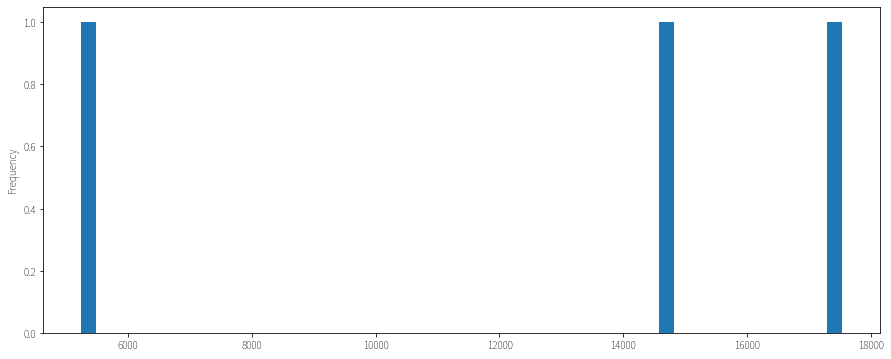

In [42]:
df[df["k_class"]==4]["floor_area"].plot.hist(bins=50)

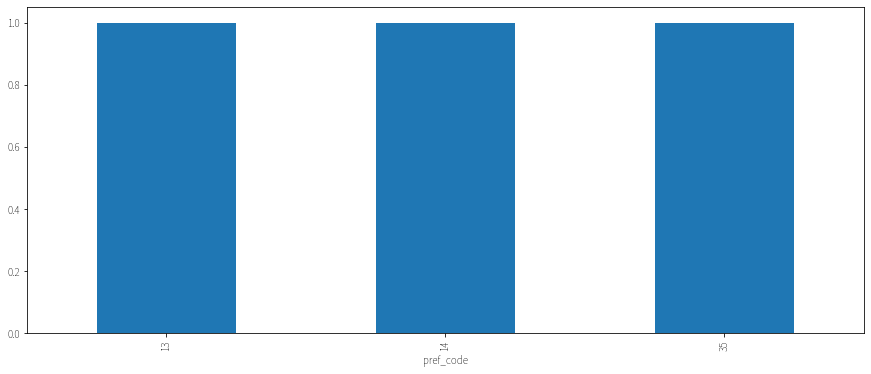

In [43]:
df[df["k_class"]==4].groupby("pref_code").size().plot.bar()

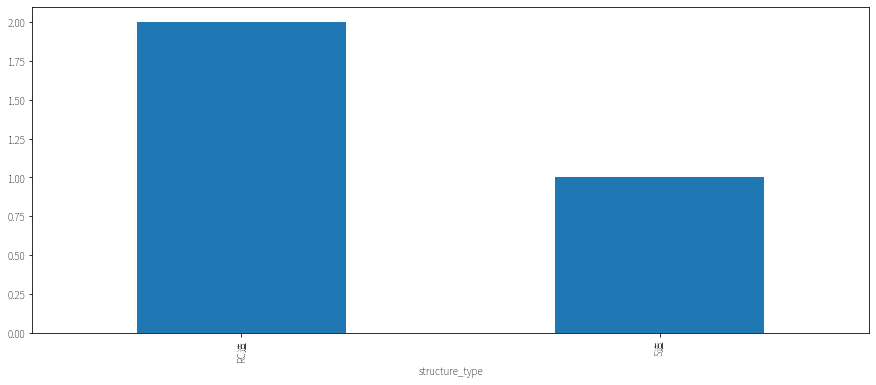

In [44]:
df[df["k_class"]==4].groupby("structure_type").size().plot.bar()

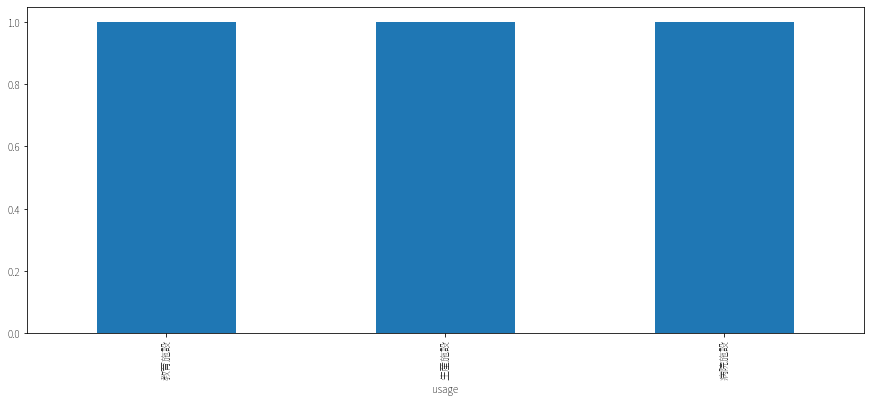

In [45]:
df[df["k_class"]==4].groupby("usage").size().plot.bar()

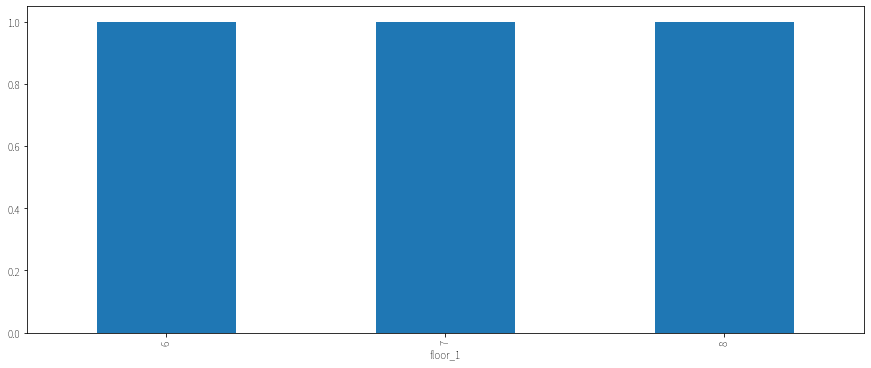

In [46]:
df[df["k_class"]==4].groupby("floor_1").size().plot.bar()

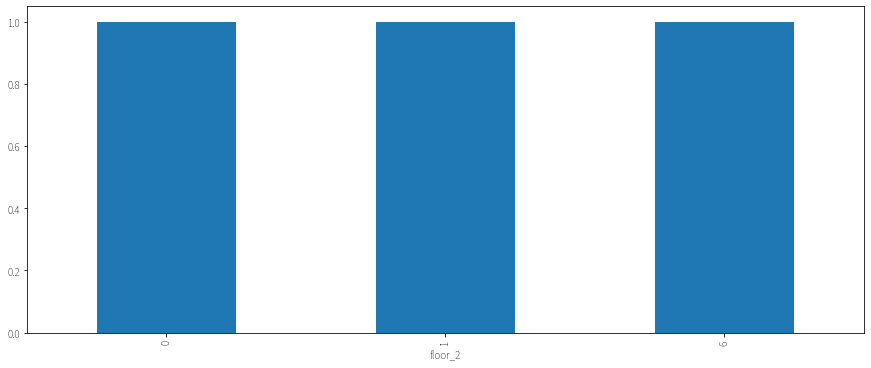

In [47]:
df[df["k_class"]==4].groupby("floor_2").size().plot.bar()

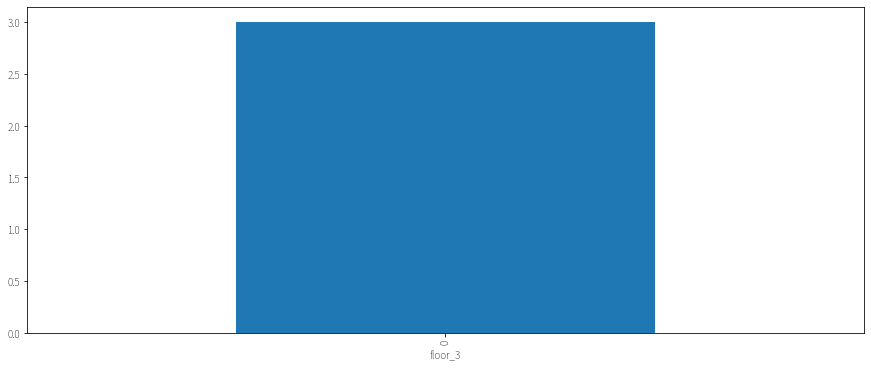

In [48]:
df[df["k_class"]==4].groupby("floor_3").size().plot.bar()

In [49]:
df[df["k_class"]==4]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
309,79 10B430B,ポーラ横浜研究所跡地有効活用計画,生産施設,神奈川県横浜市神奈川区,14593.00,6-6-0,RC造,14,392,6,6,0,4
317,79 12A292T,山陽小野田市民病院新築工事,病院施設,山口県山陽小野田市大字東高泊１８６３−１,17524.30,8-0-0,S造,35,392,8,0,0,4
571,79 13A454E,東京大学（本郷）地下書庫躯体新営工事,教育施設,東京都文京区,5243.49,7-1-0,RC造,13,392,7,1,0,4


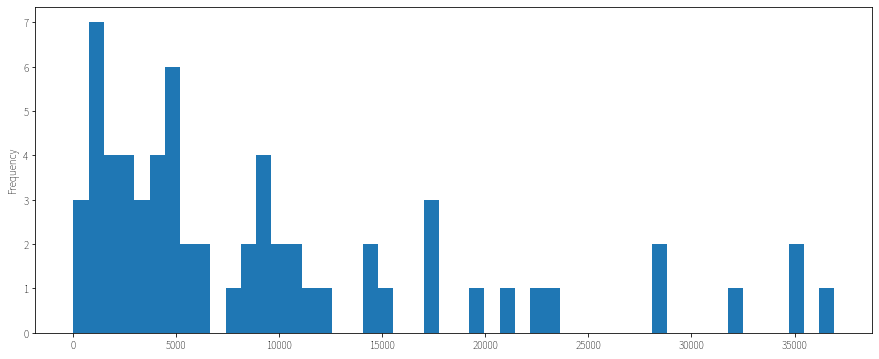

In [50]:
df[df["k_class"]==5]["floor_area"].plot.hist(bins=50)

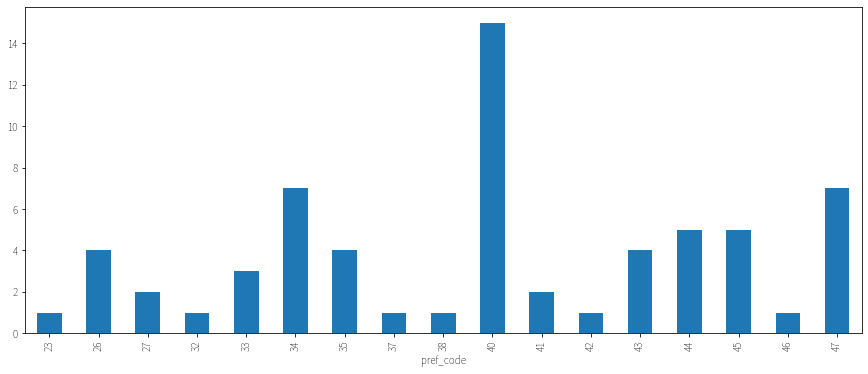

In [51]:
df[df["k_class"]==5].groupby("pref_code").size().plot.bar()

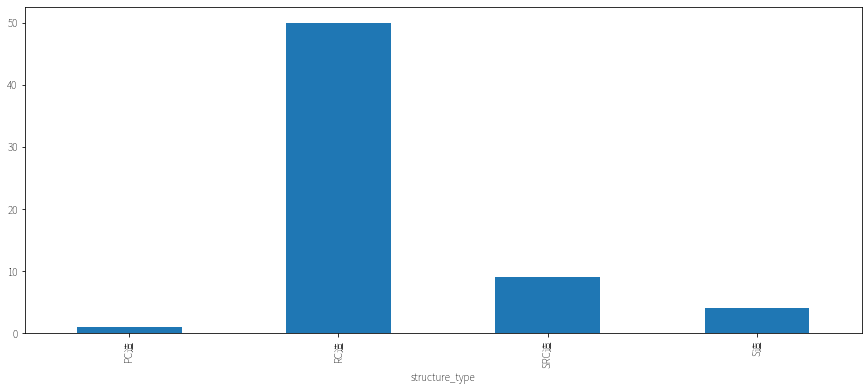

In [52]:
df[df["k_class"]==5].groupby("structure_type").size().plot.bar()

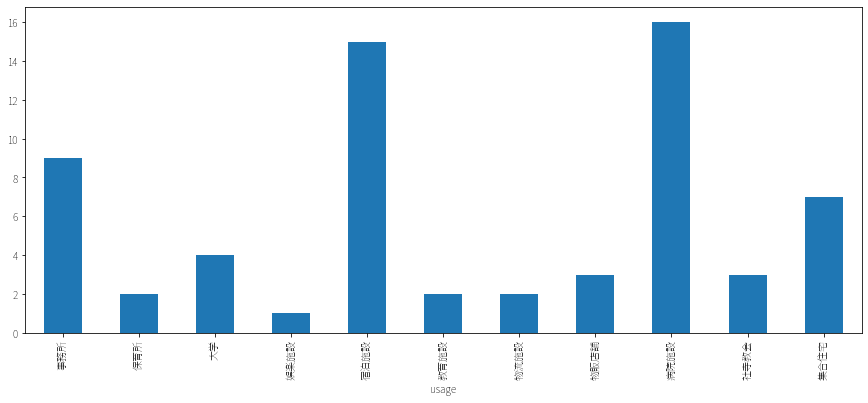

In [53]:
df[df["k_class"]==5].groupby("usage").size().plot.bar()

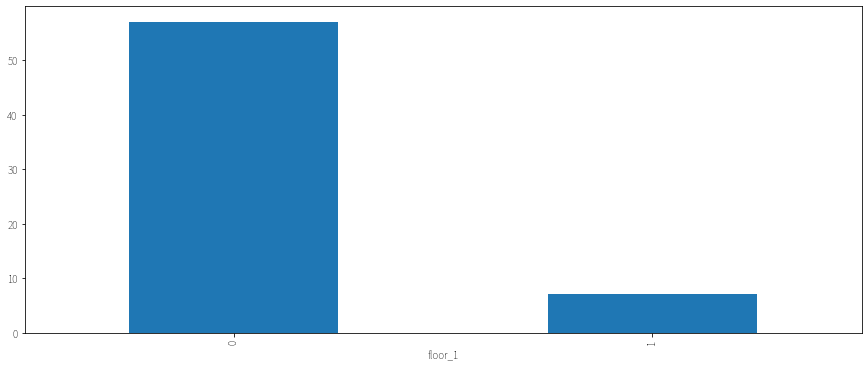

In [54]:
df[df["k_class"]==5].groupby("floor_1").size().plot.bar()

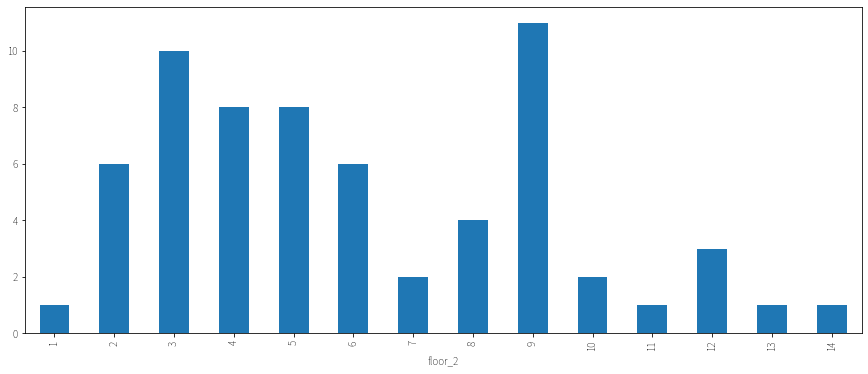

In [55]:
df[df["k_class"]==5].groupby("floor_2").size().plot.bar()

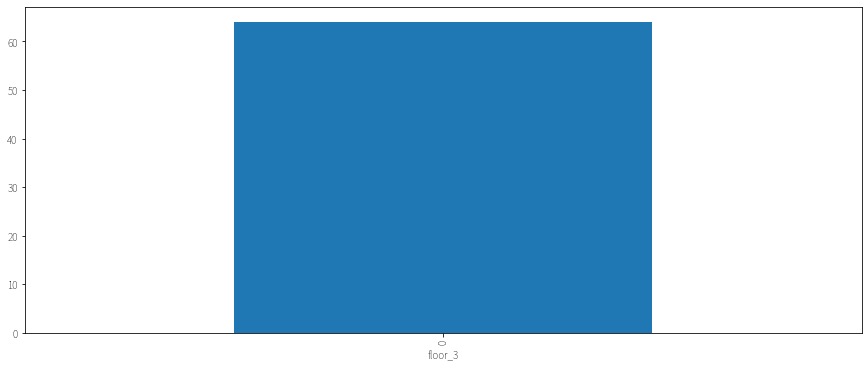

In [56]:
df[df["k_class"]==5].groupby("floor_3").size().plot.bar()

In [57]:
df[df["k_class"]==5]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
8,79 09A556A,※東邦薬品熊本物流センター計画,物流施設,熊本県荒尾市,15278.40,0-2-0,RC造,43,392,0,2,0,5
18,74 08B005A,宮崎県民共済自社ビル（設計変更対応）,事務所,宮崎県宮崎市宮脇町１２７−１,3000.00,0-5-0,RC造,45,392,0,5,0,5
33,74S09A004,すがお内科クリニック新築工事,病院施設,福岡県福岡市城南区,223.00,0-2-0,RC造,40,392,0,2,0,5
46,74 09A034,大分サレジアンシスターズ修道院聖堂改築,社寺教会,大分県大分市,2104.75,0-3-0,RC造,44,392,0,3,0,5
57,74 09B062,南ケ丘第二幼稚園計画,保育所,福岡県大野城市,1425.00,0-2-0,RC造,40,392,0,2,0,5
59,74 10B033,やましたクリニック計画,病院施設,福岡県福岡市博多区,2589.62,0-5-0,RC造,40,392,0,5,0,5
75,74 10A011,ウエルライフ３号館新築工事,集合住宅,宮崎県都城市,9954.40,0-4-0,RC造,45,392,0,4,0,5
88,72 08B041A,中央内科クリニック整備計画,病院施設,広島県呉市,3971.00,0-4-0,RC造,34,392,0,4,0,5
173,72 09B018A,（仮称）ハートフルハウス新築計画,病院施設,広島県廿日市市,1818.79,0-3-0,RC造,34,392,0,3,0,5
184,74S11B004,ＦＨＳ敷地有効利用計画,物販店舗,福岡県福岡市早良区,19350.00,0-9-0,S造,40,392,0,9,0,5


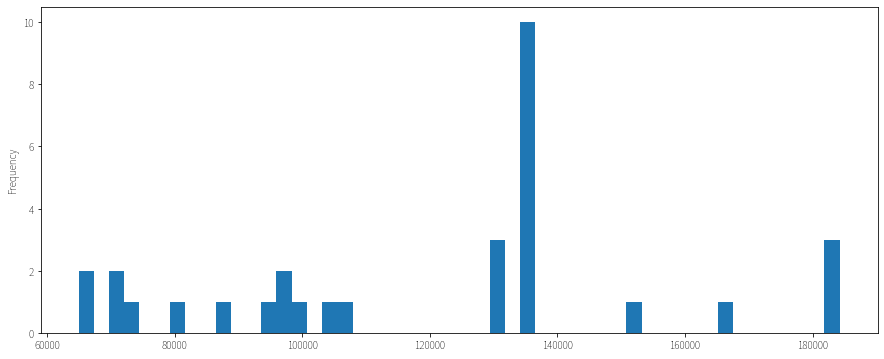

In [58]:
df[df["k_class"]==6]["floor_area"].plot.hist(bins=50)

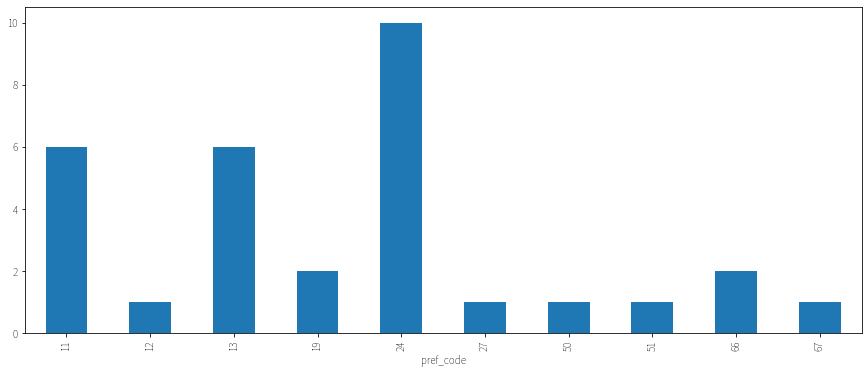

In [59]:
df[df["k_class"]==6].groupby("pref_code").size().plot.bar()

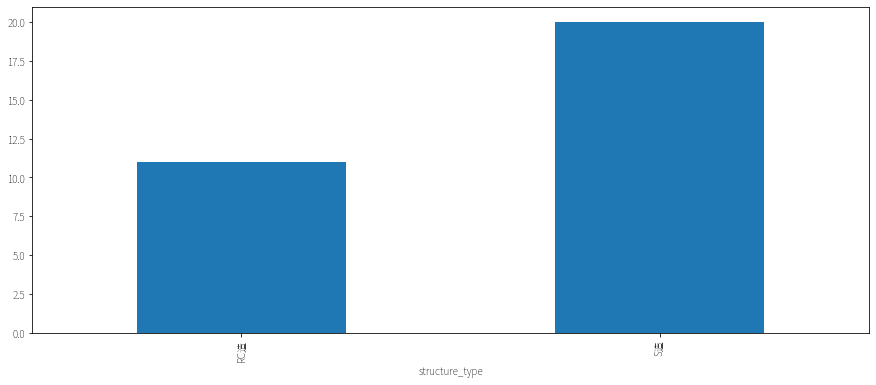

In [60]:
df[df["k_class"]==6].groupby("structure_type").size().plot.bar()

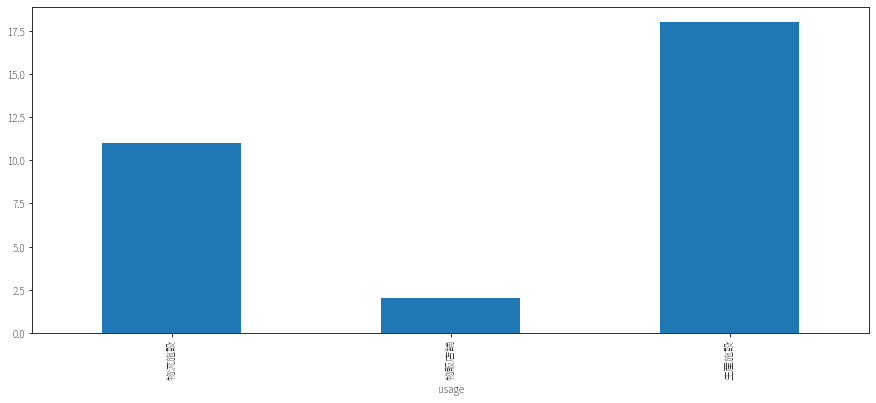

In [61]:
df[df["k_class"]==6].groupby("usage").size().plot.bar()

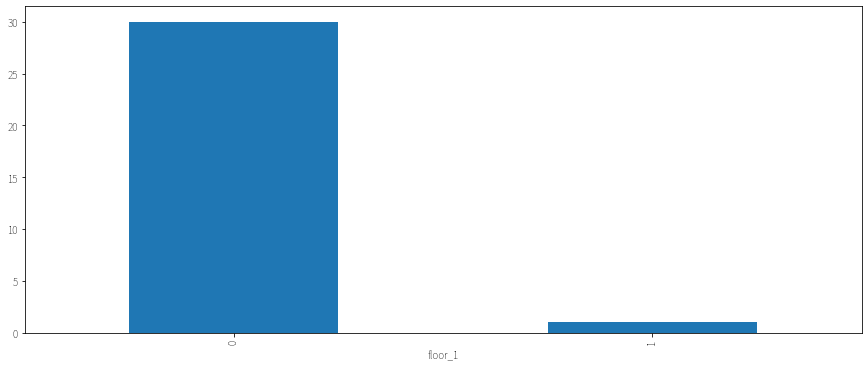

In [62]:
df[df["k_class"]==6].groupby("floor_1").size().plot.bar()

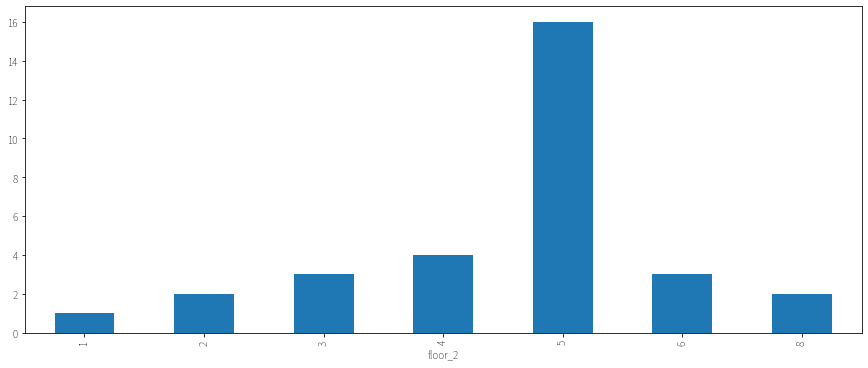

In [63]:
df[df["k_class"]==6].groupby("floor_2").size().plot.bar()

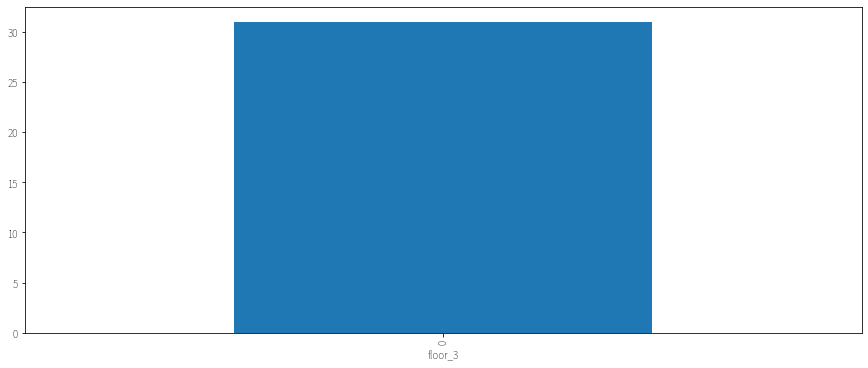

In [64]:
df[df["k_class"]==6].groupby("floor_3").size().plot.bar()

In [65]:
df[df["k_class"]==6]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
14,79 08A148B,イオンモール甲府昭和町ＳＣジャスコＢ工事,物販店舗,山梨県中巨摩郡昭和町,70657.00,0-3-0,S造,19,392,0,3,0,6
24,79 08A148E,イオンモール甲府昭和町ＳＣ（熱源受託工事,物販店舗,山梨県中巨摩郡昭和町,70657.00,0-3-0,RC造,19,392,0,3,0,6
29,79 07B471B,プロロジスパーク埼玉川島Ⅱ期,物流施設,埼玉県比企郡川島町,166659.70,0-5-1,RC造,11,392,0,5,0,6
73,79 10B200A,ホンダ寄居工場建設１期建築工事Ｓ工区,生産施設,埼玉県大里郡寄居町,184227.00,0-4-0,S造,11,392,0,4,0,6
77,79 08A090D,東芝四日市メモリ第５製造棟（棟間搬送）,生産施設,三重県四日市市,96000.00,0-5-0,S造,24,392,0,5,0,6
149,93 10A006S,ブリヂストンインド第２工場新築工事,生産施設,海外インド マハラシュトプネ,96846.36,0-1-0,S造,51,356,0,1,0,6
223,79 11A027B,合肥ニプロ新工場建設工事,生産施設,海外中国 安微省,100463.00,0-2-1,RC造,67,156,0,2,0,6
237,79 11A860A,※ＨＭＳＩ第３工場建設工事,生産施設,海外インド カルナタカ州,151950.19,0-2-0,S造,50,356,0,2,0,6
251,79 10B522B,プロロジスパーク習志野４,物流施設,千葉県習志野市,107546.00,0-5-1,RC造,12,392,0,5,0,6
401,79 11B506B,東芝四日市２５０棟設計検討（３期）２,生産施設,三重県四日市市,93642.26,1-6-0,S造,24,392,1,6,0,6


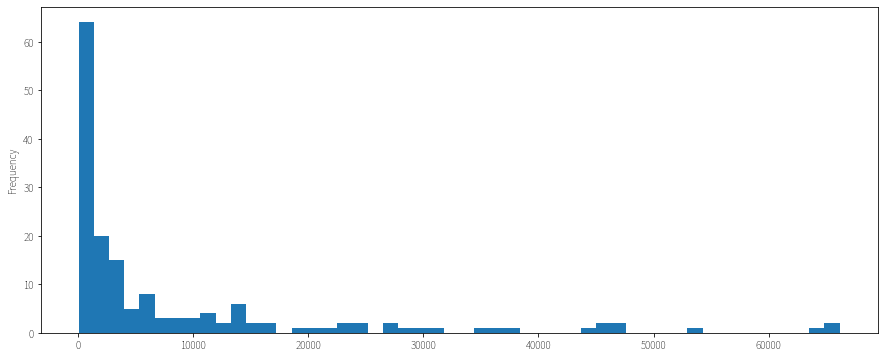

In [66]:
df[df["k_class"]==7]["floor_area"].plot.hist(bins=50)

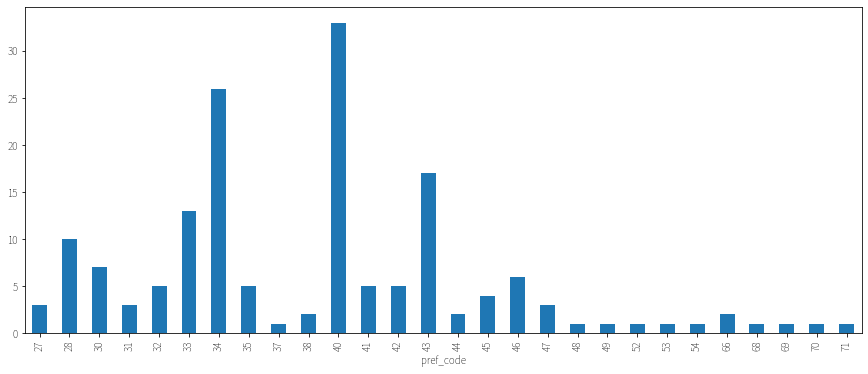

In [67]:
df[df["k_class"]==7].groupby("pref_code").size().plot.bar()

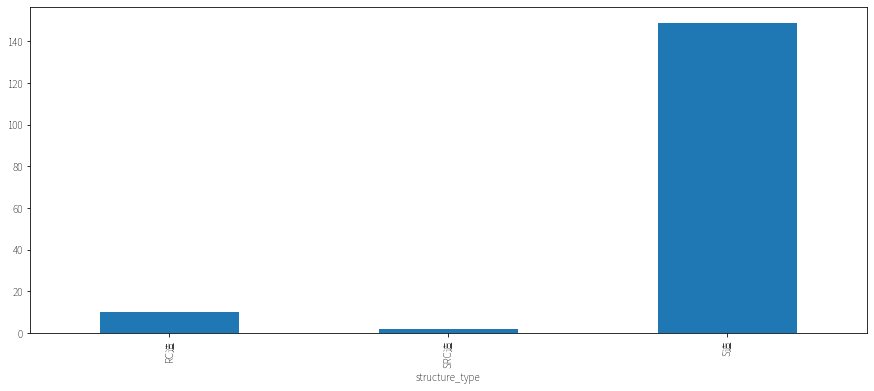

In [68]:
df[df["k_class"]==7].groupby("structure_type").size().plot.bar()

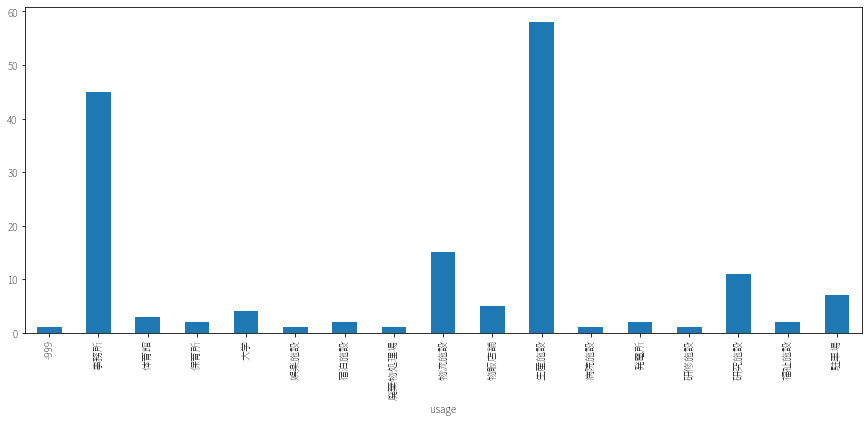

In [69]:
df[df["k_class"]==7].groupby("usage").size().plot.bar()

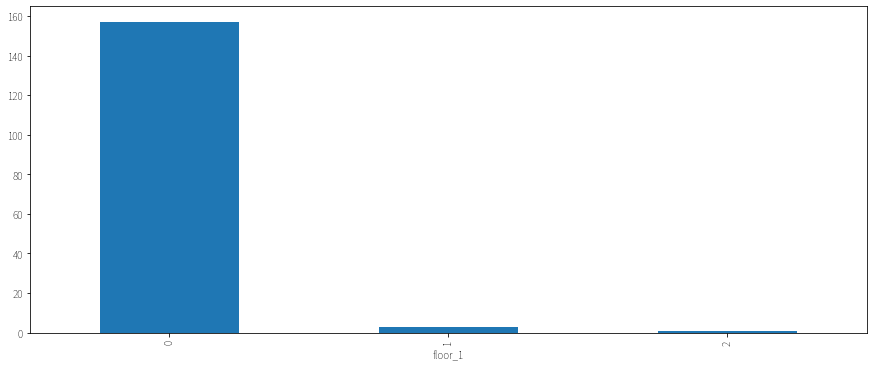

In [70]:
df[df["k_class"]==7].groupby("floor_1").size().plot.bar()

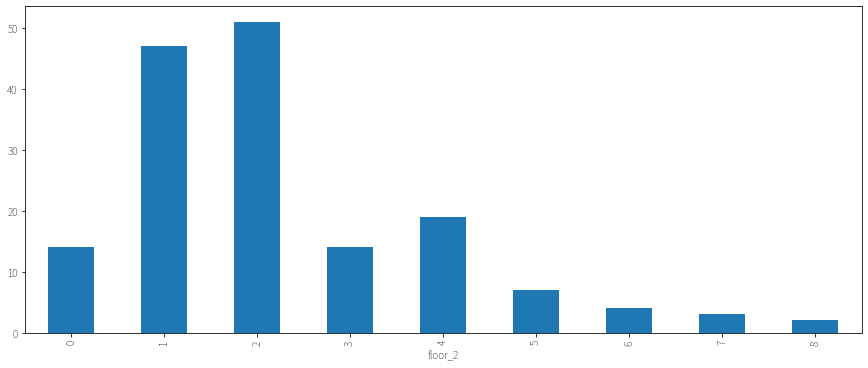

In [71]:
df[df["k_class"]==7].groupby("floor_2").size().plot.bar()

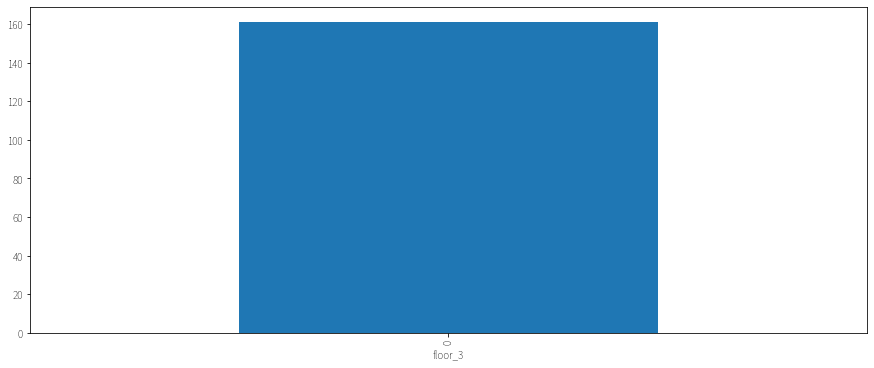

In [72]:
df[df["k_class"]==7].groupby("floor_3").size().plot.bar()

In [73]:
df[df["k_class"]==7]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
6,79 09A540A,花王和歌山新研究施設建設計画,研究施設,和歌山県和歌山市,22234.090,0-7-2,S造,30,392,0,7,0,7
7,79 09A540C,花王和歌山新研究施設建設計画（温室）,研究施設,和歌山県和歌山市,2361.000,0-3-0,S造,30,392,0,3,0,7
12,74 09A089,熊本工機本社工場荷捌き場新築工事,生産施設,熊本県玉名郡南関町大字四ﾂ原1280,110.000,0-1-0,S造,43,392,0,1,0,7
15,79 09B033B,シャープ福山第２センタービル計画,事務所,広島県福山市,10000.000,0-5-0,S造,34,392,0,5,0,7
17,93 09A039,コベルコ建機インド新工場建設工事,研究施設,海外インド SRI-CITY,5992.000,0-2-0,SRC造,48,356,0,2,0,7
25,74 09A011,ゆめマートうきは新築工事,物販店舗,福岡県うきは市,9934.910,0-1-0,S造,40,392,0,1,0,7
36,74 09A054,ふたば幼稚園子育て支援施設計画,保育所,佐賀県佐賀市,300.000,0-1-0,RC造,41,392,0,1,0,7
40,72 09A031A,大山町農産物処理加工施設建設（実施）,生産施設,鳥取県西伯郡大山町,491.570,0-1-0,S造,31,392,0,1,0,7
41,93 09A013,常州ピジョン新工場新築工事,研究施設,海外中国 江蘇省,13800.000,0-2-0,RC造,69,156,0,2,0,7
42,93 09A012,アーレスティ広州金型工場建設工事,生産施設,海外中国 広東省,2520.000,0-1-0,RC造,68,156,0,1,0,7


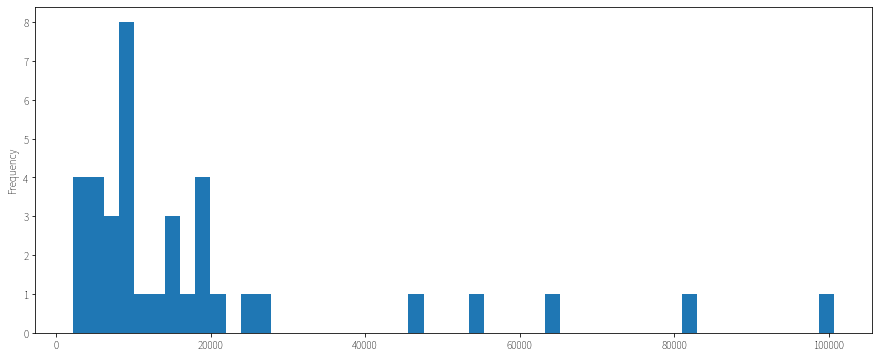

In [74]:
df[df["k_class"]==8]["floor_area"].plot.hist(bins=50)

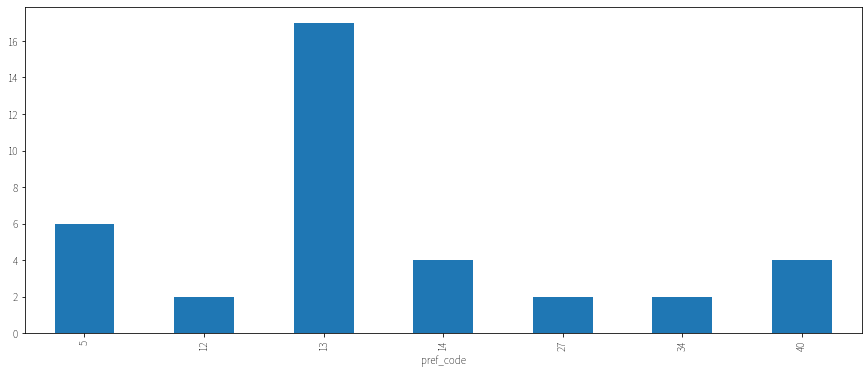

In [75]:
df[df["k_class"]==8].groupby("pref_code").size().plot.bar()

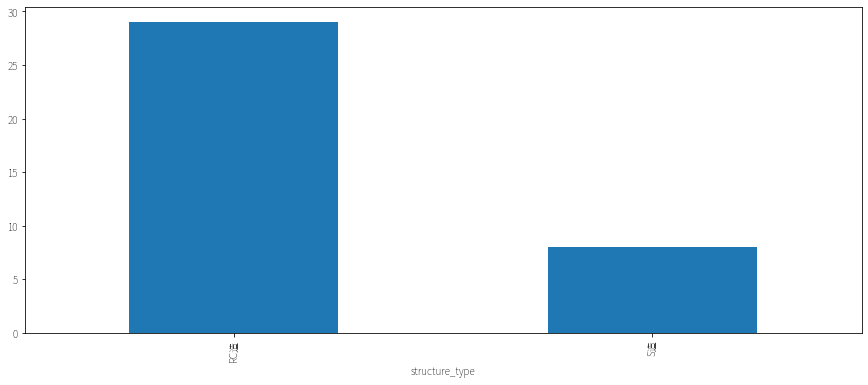

In [76]:
df[df["k_class"]==8].groupby("structure_type").size().plot.bar()

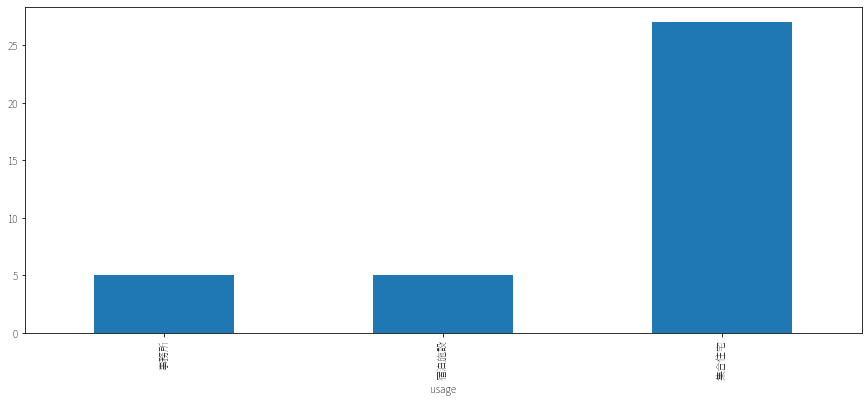

In [77]:
df[df["k_class"]==8].groupby("usage").size().plot.bar()

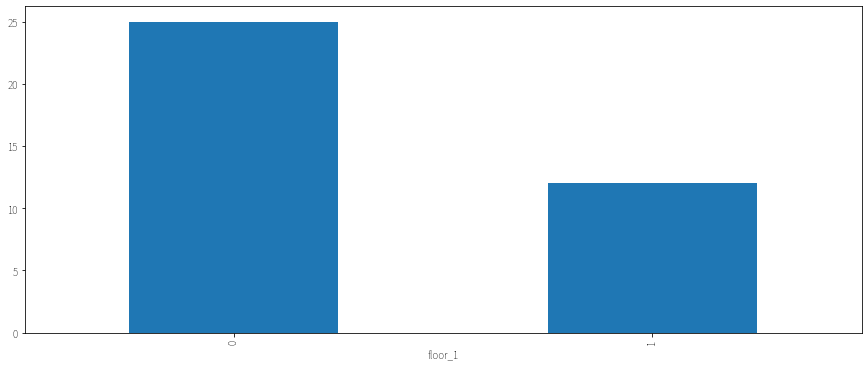

In [78]:
df[df["k_class"]==8].groupby("floor_1").size().plot.bar()

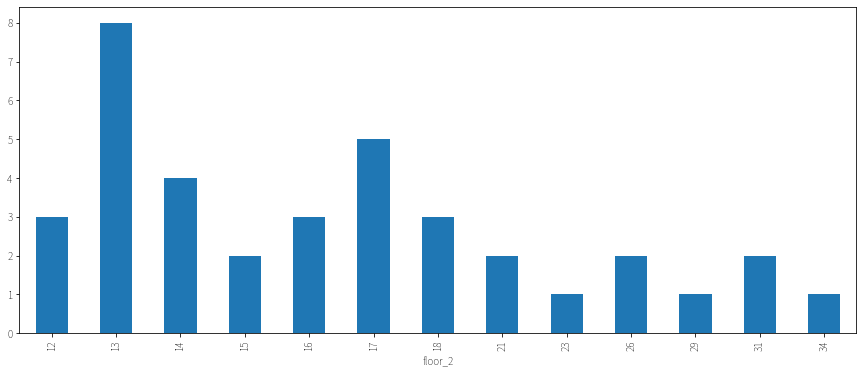

In [79]:
df[df["k_class"]==8].groupby("floor_2").size().plot.bar()

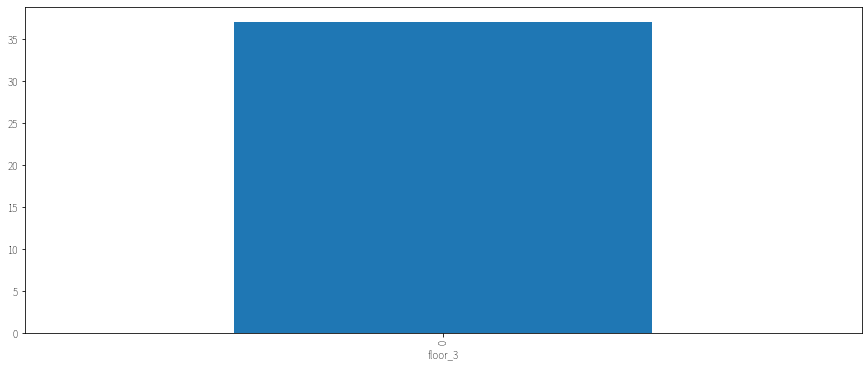

In [80]:
df[df["k_class"]==8].groupby("floor_3").size().plot.bar()

In [81]:
df[df["k_class"]==8]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
5,79 04B878C,市川一丁目計画（テナント対応）,集合住宅,千葉県市川市,7218.81,1-13-0,RC造,12,392,1,13,0,8
112,79 09B263A,南麻布１丁目計画,集合住宅,東京都港区,2306.78,0-12-0,RC造,13,392,0,12,0,8
122,79 10A236A,※千代田区四番町計画,集合住宅,東京都千代田区,21884.00,1-15-1,RC造,13,392,1,15,0,8
125,79 05A058E,月島一丁目地区再開発計画（Ｂ棟）,集合住宅,東京都中央区,3417.16,1-12-0,RC造,13,392,1,12,0,8
196,79 07A752H,芝浦一丁目計画（設計）,集合住宅,東京都港区,100758.02,0-34-1,RC造,13,392,0,34,0,8
243,79 11A726A,渋谷水野ビル建替計画,集合住宅,東京都渋谷区,8027.51,1-18-1,RC造,13,392,1,18,0,8
246,76 10A018A,中通一丁目再開発住宅棟パンフレット支援,集合住宅,秋田県秋田市,9936.00,0-13-0,RC造,5,392,0,13,0,8
249,79 09B161B,本郷一丁目プロジェクト,集合住宅,東京都文京区,9964.00,1-17-1,RC造,13,392,1,17,0,8
253,79 07B171G,調布駅南口東地区再開発計画,集合住宅,東京都調布市,25372.09,1-16-1,RC造,13,392,1,16,0,8
264,79 10B172B,新豊洲プロジェクトＢ－２地区計画,集合住宅,東京都江東区,64549.44,1-31-1,RC造,13,392,1,31,0,8


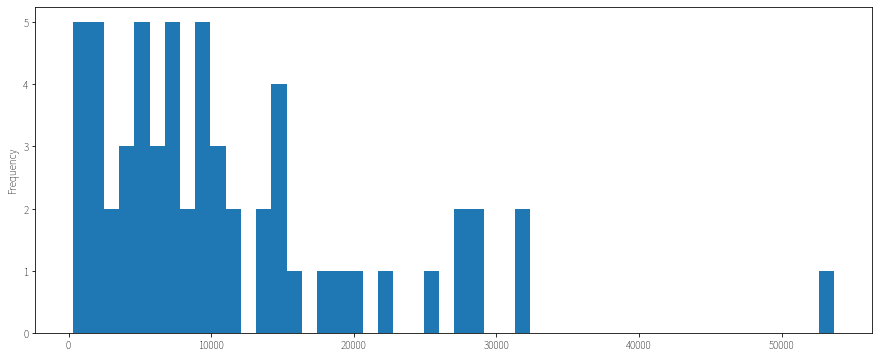

In [82]:
df[df["k_class"]==9]["floor_area"].plot.hist(bins=50)

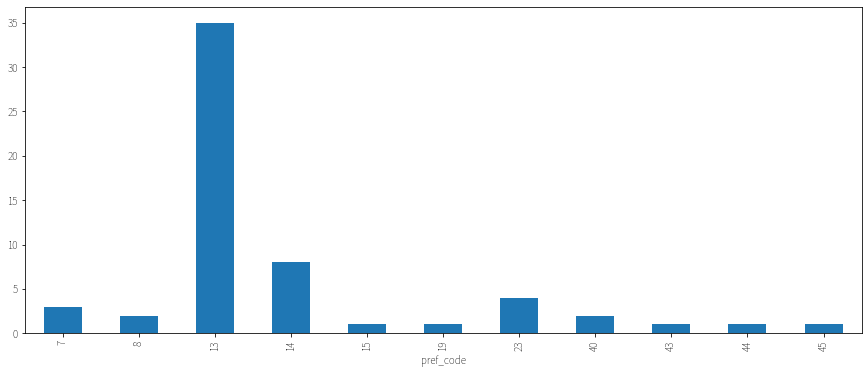

In [83]:
df[df["k_class"]==9].groupby("pref_code").size().plot.bar()

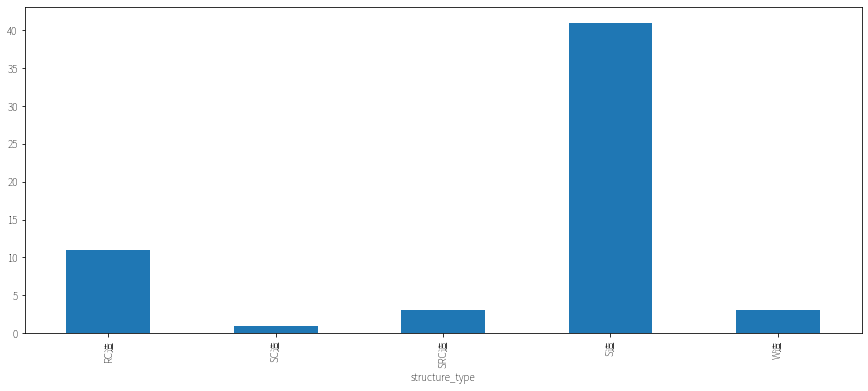

In [84]:
df[df["k_class"]==9].groupby("structure_type").size().plot.bar()

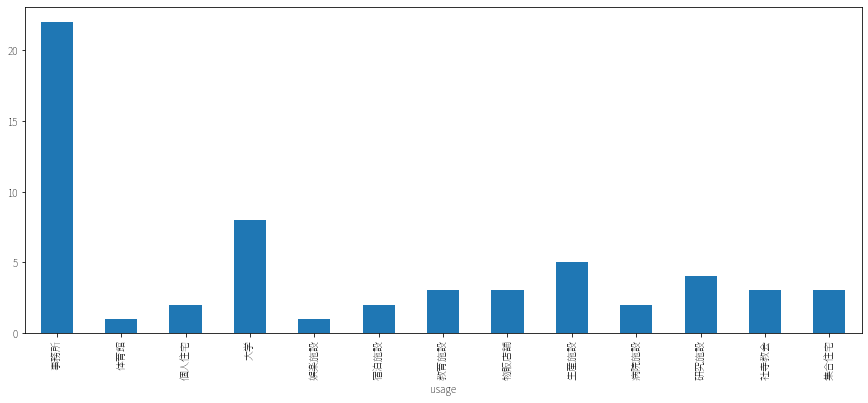

In [85]:
df[df["k_class"]==9].groupby("usage").size().plot.bar()

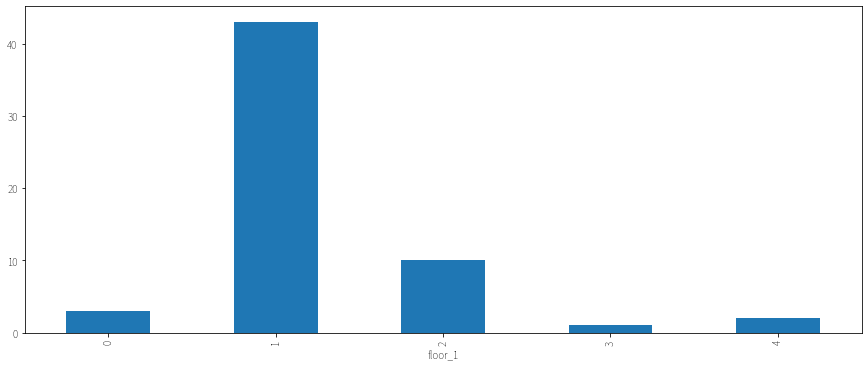

In [86]:
df[df["k_class"]==9].groupby("floor_1").size().plot.bar()

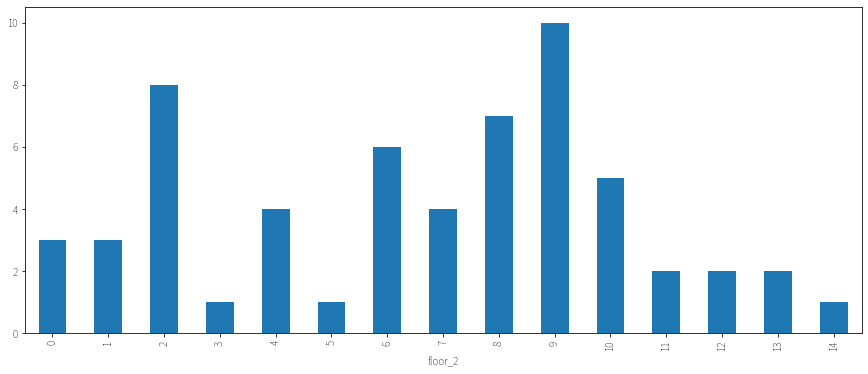

In [87]:
df[df["k_class"]==9].groupby("floor_2").size().plot.bar()

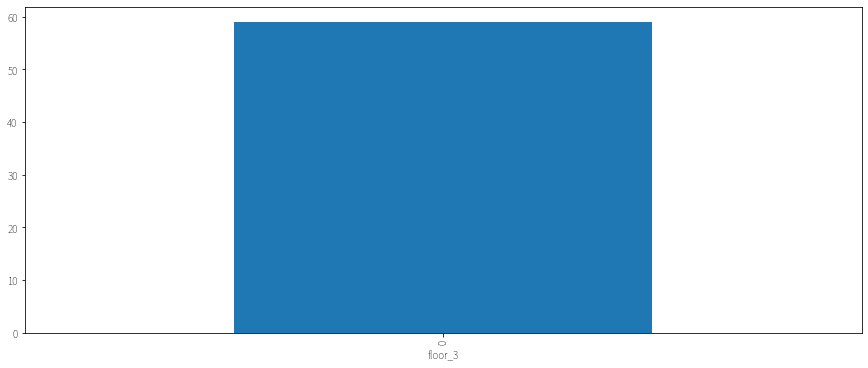

In [88]:
df[df["k_class"]==9].groupby("floor_3").size().plot.bar()

In [89]:
df[df["k_class"]==9]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,14,392,1,6,0,9
11,79 06B190B,上野学園ホール棟テナントＡ対応,大学,東京都台東区,15948.79,2-13-0,SRC造,13,392,2,13,0,9
20,79 09A276B,日本ガス協会ビル建替事業,事務所,東京都港区,7477.29,1-9-1,S造,13,392,1,9,0,9
38,79 08B173A,川崎御幸ビルディング建替計画,事務所,神奈川県川崎市川崎区,6690.80,1-9-1,S造,14,392,1,9,0,9
50,79 09B514A,大和ハウス工業 南青山六丁目計画,集合住宅,東京都港区,13783.21,2-8-0,RC造,13,392,2,8,0,9
61,79 08B173B,川崎御幸ビル新築工事に伴うテナント工事,事務所,神奈川県川崎市川崎区,6634.67,1-9-0,S造,14,392,1,9,0,9
81,79 09B418A,チェックイン新橋第３ホテル新築工事,宿泊施設,東京都港区,1326.88,1-12-0,S造,13,392,1,12,0,9
113,79 09B264A,狸穴マンション計画,集合住宅,東京都港区,18161.34,2-8-0,RC造,13,392,2,8,0,9
121,79 09B389A,虎ノ門１丁目計画,事務所,東京都港区,5172.70,1-12-1,S造,13,392,1,12,0,9
132,64 10A017,日立ハイテクノロジーズ那珂総合棟構造検討,事務所,茨城県ひたちなか市,25602.00,1-7-0,S造,8,392,1,7,0,9


In [90]:
df.groupby("structure_type").size()

structure_type
CB造       2
PC造       1
RC造     249
SC造       1
SRC造     21
S造      548
W造       15
dtype: int64